In [ ]:
import math
import pathlib
import typing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import albumentations as A
import multiprocessing
from collections import Counter
from tqdm import tqdm
from functools import cached_property

import os

import pandas as pd
import time
import pickle

from matplotlib.ticker import MaxNLocator
from keras.src import callbacks
from utils_and_constants import labels, TARGET_SIZE
from sklearn.model_selection import train_test_split
from focal_loss import SparseCategoricalFocalLoss

# import segmentation_models as sm

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["NO_ALBUMENTATIONS_UPDATES"] = "1"

np.random.seed(314)
tf.random.set_seed(314)

print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())

Number of CPU cores available:  16


# 1. Préparation & Chargement des données
----------------

## 1.1. Présentation du jeu de données

Voici une visualisation de l'arborescence du jeu de données `Cityscapes` tel qu'il m'a été fourni après décompression de l'archive:

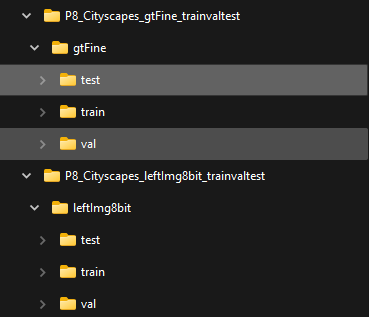

On trouve les deux principaux répertoires `gtFine` et `leftImg8bit` qui contiennent respectivement les annotations et les images brutes.<br>
Chacun de ces répertoires est ensuite subdivisé en trois sous répertoires, qui eux mêmes contiennent des sous-répertoires en fonction des villes:
- `train` contenant les données d'entraînement (2975 images)
- `val` contenant les données de validation  (500 images)
- `test` dont les annotations ne sont pas rendues publiques, donc inexploitables dans le cas présent (1525 images)


Zoom sur les fichiers se trouvant dans le répertoire `gtFine`:

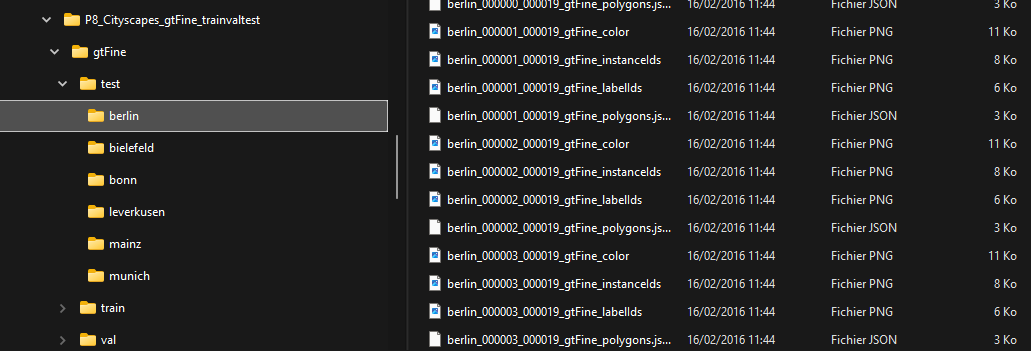

Zoom sur les fichiers se trouvant dans le répertoire `leftImg8bit`:

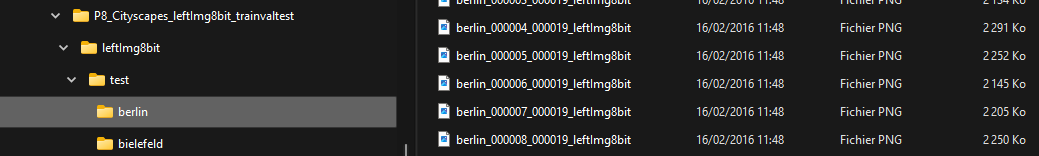

**Voici une analyse de sa composition :**
- Un répertoire `gtFine` contenant les images de masques annotées (20 000 fichiers). Chaque image se distingue par 4 fichiers différents:
    - Un fichier `color` en couleurs (5 000 fichiers png)
    - Un fichier `instanceIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `labelIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `polygons` contenant les coordonnées des zones segmentéees (5 000 fichiers json)
- Un répertoire `leftImg8bit` contenant les images brutes en couleurs (5 000 fichiers)

**Pour plus d'informations sur le dataset, merci de lire le README suivant : https://github.com/mcordts/cityscapesScripts/blob/master/README.md**


## 1.2. Préparation des dossiers et des données de travail

La première étape consiste à préparer les dossiers pour le jeu d'entraînement, de validation en conservant les fichiers d'intérêt:
- On écarte les dossiers `test` qui ne contiennent pas les annotations
- On va utiliser le dosser `val` pour les données de `test` et j'exécuterai un split pour recréer des données de validation.
- On conserve les fichiers `labelIds` et `color` pour les masques en niveaux de gris et en couleur respectivement.
- On converse les fichiers `Img8bit` pour les images en RGB.
**Premièrement, on ignore les dossiers de test puisque nous n'avons pas accès aux annotations.**<br>


Pour reproduire les préparations, voici le code à exécuter dans le terminal ou via un script `shell`:

```bash
find ./data/Raw/P8_Cityscapes_leftImg8bit_trainvaltest/train -type f \( -iname "*leftImg8bit.png" \) -exec mv {} ./data/Sorted/train/ \;
find ./data/Raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftimg8bit/train -type f \( -iname "*leftImg8bit.png" \) -exec mv {} ./data/Sorted/train/ \;
find ./data/Raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train -type f \( -iname "*leftImg8bit.png" \) -exec mv {} ./data/Sorted/train/ \;
find ./data/Raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftimg8bit/val -type f \( -iname "*leftImg8bit.png" \) -exec mv {} ./data/Sorted/test/ \;
find ./data/Raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val -type f \( -iname "*leftImg8bit.png" \) -exec mv {} ./data/Sorted/test/ \;
find ./data/Raw/P8_Cityscapes_gtFine_trainvaltest/gtFine/train -type f \( -iname "*gtFine_color.png" -o -iname "*gtFine_labelIds.png" \) -exec mv {} ./data/Sorted/train/ \;
find ./data/Raw/P8_Cityscapes_gtFine_trainvaltest/gtFine/val -type f \( -iname "*gtFine_color.png" -o -iname "*gtFine_labelIds.png" \) -exec mv {} ./data/Sorted/test/ \;
```

## 1.3. Les labels

Le repo github contient notamment un script, importé dans `utils_and_constants.py` qui permets de créer des NameTuples pour chaque label, ce qui permet de les manipuler plus facilement.<br>
A l'origine, **les annotations en niveaux de gris ont 35 valeurs possibles.**<br>


Nous allons nous restreindre **aux 8 catégories simplifiées, qui constitueront nos classes de segmentation** que l'on peut voir ci-dessous à l'index 3 de chaque NamedTuple:
```python
# Define the list of labels namedtuples
labels = [
    Label("unlabeled", 0, 255, "void", 0, False, True, (0, 0, 0)),
    Label("ego vehicle", 1, 255, "void", 0, False, True, (0, 0, 0)),
    Label("rectification border", 2, 255, "void", 0, False, True, (0, 0, 0)),
    Label("out of roi", 3, 255, "void", 0, False, True, (0, 0, 0)),
    Label("static", 4, 255, "void", 0, False, True, (0, 0, 0)),
    Label("dynamic", 5, 255, "void", 0, False, True, (111, 74, 0)),
    Label("ground", 6, 255, "void", 0, False, True, (81, 0, 81)),
    Label("road", 7, 0, "flat", 1, False, False, (128, 64, 128)),
    Label("sidewalk", 8, 1, "flat", 1, False, False, (244, 35, 232)),
    Label("parking", 9, 255, "flat", 1, False, True, (250, 170, 160)),
    Label("rail track", 10, 255, "flat", 1, False, True, (230, 150, 140)),
    Label("building", 11, 2, "construction", 2, False, False, (70, 70, 70)),
    Label("wall", 12, 3, "construction", 2, False, False, (102, 102, 156)),
    Label("fence", 13, 4, "construction", 2, False, False, (190, 153, 153)),
    Label("guard rail", 14, 255, "construction", 2, False, True, (180, 165, 180)),
    Label("bridge", 15, 255, "construction", 2, False, True, (150, 100, 100)),
    Label("tunnel", 16, 255, "construction", 2, False, True, (150, 120, 90)),
    Label("pole", 17, 5, "object", 3, False, False, (153, 153, 153)),
    Label("polegroup", 18, 255, "object", 3, False, True, (153, 153, 153)),
    Label("traffic light", 19, 6, "object", 3, False, False, (250, 170, 30)),
    Label("traffic sign", 20, 7, "object", 3, False, False, (220, 220, 0)),
    Label("vegetation", 21, 8, "nature", 4, False, False, (107, 142, 35)),
    Label("terrain", 22, 9, "nature", 4, False, False, (152, 251, 152)),
    Label("sky", 23, 10, "sky", 5, False, False, (70, 130, 180)),
    Label("person", 24, 11, "human", 6, True, False, (220, 20, 60)),
    Label("rider", 25, 12, "human", 6, True, False, (255, 0, 0)),
    Label("car", 26, 13, "vehicle", 7, True, False, (0, 0, 142)),
    Label("truck", 27, 14, "vehicle", 7, True, False, (0, 0, 70)),
    Label("bus", 28, 15, "vehicle", 7, True, False, (0, 60, 100)),
    Label("caravan", 29, 255, "vehicle", 7, True, True, (0, 0, 90)),
    Label("trailer", 30, 255, "vehicle", 7, True, True, (0, 0, 110)),
    Label("train", 31, 16, "vehicle", 7, True, False, (0, 80, 100)),
    Label("motorcycle", 32, 17, "vehicle", 7, True, False, (0, 0, 230)),
    Label("bicycle", 33, 18, "vehicle", 7, True, False, (119, 11, 32)),
    Label("license plate", -1, -1, "vehicle", 7, False, True, (0, 0, 142)),
]
```

## 1.4. ***Chargement des données***

Je travaillerai sur une taille de `256x512` pour des raisons de performances.<br>
La variable TARGET_SIZE est définie dans le fichier `utils_and_constants.py`.

```python
TARGET_SIZE = (256, 512)
```

J'ai créé la classe `ImageSegmentationDataset` pour charger les données.<br>
Cette classe hérite de `tf.keras.utils.PyDataset` pour optimiser le chargement des données au modèle.<br>
Elle prend **en entrée les chemins des images et des masques, et les charge en mémoire pour les fournir au modèle.**


**La classe permets d'effectuer les transformations suivantes si nécessaire:**
- Redimensionner les images et les masques. Je travaillerai sur une taille de `256x512` pour des raisons de performances.
- Normaliser les images
- Appliquer des transformations aléatoires pour augmenter le jeu de données via un pipeline de transformation `albumentations`
- La conversion des labels en 8 classes simplifiées
- La possibilité d'ajouter un mask de poids pour les classes déséquilibrées
- La possibilité de mélanger les données à la fin de chaque époch et au début de l'entraînement
- La possibilité de convertir les labels en one-hot encoding


**J'ai également ajouté à la classe des fonctions utilitaires de visualisation et de traitement des données pour faciliter l'analyse et la compréhension des données et qui ne nécessitent pas de charger les batchs tout en profitant de performances optimales.**

In [28]:
class ImageSegmentationDataset(tf.keras.utils.PyDataset):
    """
    Dataset generator for image segmentation tasks.

    This class extends the PyDataset utility from TensorFlow/Keras and provides data
    loading, optional augmentation, and preprocessing for both images and corresponding segmentation masks.

    Attributes:
        image_paths (List[pathlib.Path]): List of image file paths.
        mask_paths (List[pathlib.Path]): List of corresponding mask file paths.
        table_id2category (dict): Mapping from label id to category id.
        table_category2name (dict): Mapping from category id to category name.
        batch_size (int): Number of samples per batch.
        target_size (Tuple[int, int]): Target dimensions (height, width) for resizing images and masks.
        augmentations (bool): Flag to determine if augmentation pipeline should be applied.
        normalize (bool): Flag to normalize image values to [0, 1].
        shuffle (bool): Whether to shuffle the dataset at the end of every epoch.
        label_onehot (bool): If True, masks will be converted to one-hot encoded format.
        sample_weights (List[float] | None): Optional list of weights per mask label.
    """

    def __init__(
        self,
        paths: typing.List[typing.Tuple[pathlib.Path, pathlib.Path]],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: bool = False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        sample_weights: typing.List[float] = None,
        **kwargs,
    ):
        """
        Initialize the ImageSegmentationDataset.

        Args:
            paths (List[Tuple[pathlib.Path, pathlib.Path]]): List of tuples containing image and mask paths.
            labels (typing.NamedTuple): Named tuple with information for mapping labels (e.g., id, categoryId, category).
            batch_size (int): Number of samples per batch.
            target_size (Tuple[int, int]): Target size for resizing images and masks (height, width).
            augmentations (bool, optional): Apply augmentations if True. Defaults to False.
            preview (int, optional): If provided, limits the dataset to the first 'preview' samples. Defaults to None.
            normalize (bool, optional): Normalize images by scaling to [0, 1] if True. Defaults to True.
            shuffle (bool, optional): Shuffle dataset on each epoch end. Defaults to True.
            label_onehot (bool, optional): Convert masks to one-hot encoding if True. Defaults to False.
            sample_weights (List[float], optional): List of weights for mask labels. Defaults to None.
            **kwargs: Additional keyword arguments for parent class.
        """
        super().__init__(**kwargs)

        # Load the image and mask paths (apply preview slicing if needed)
        self.image_paths, self.mask_paths = self.load_img_and_mask_paths(paths, preview)

        # Create mapping tables from labels for category conversions
        self.table_id2category = {label.id: label.categoryId for label in labels}
        self.table_category2name = {
            label.categoryId: label.category for label in labels
        }

        # Initialize dataset parameters
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.sample_weights = sample_weights

        # Initialize augmentation pipeline if enabled
        if self.augmentations:
            self.compose = A.Compose(
                [
                    # Geometric transformation: Horizontal flip with probability 0.5.
                    A.HorizontalFlip(p=0.5),
                    # Color adjustments with one of the provided transformations.
                    A.OneOf(
                        [
                            A.RandomBrightnessContrast(
                                brightness_limit=0.2, contrast_limit=0.2, p=1.0
                            ),
                            A.HueSaturationValue(
                                hue_shift_limit=10,
                                sat_shift_limit=15,
                                val_shift_limit=10,
                                p=1.0,
                            ),
                        ],
                        p=0.5,
                    ),
                    # Apply blur or distortion effects.
                    A.OneOf(
                        [
                            A.GaussianBlur(blur_limit=3, p=1.0),
                            A.MotionBlur(blur_limit=5, p=1.0),
                            A.OpticalDistortion(distort_limit=0.05, p=1.0),
                        ],
                        p=0.25,
                    ),
                ],
                # If sample_weights are provided, augment them together with the masks.
                additional_targets={"sample_weights": "mask"}
                if self.sample_weights is not None
                else {},
            )

        # Shuffle dataset initially if shuffle is enabled.
        if self.shuffle:
            self.on_epoch_end()

    @cached_property
    def num_classes(self):
        """
        Return the number of unique classes in the dataset.
        The result is cached after the first calculation.
        """
        return len(set(self.table_id2category.values()))

    @cached_property
    def num_samples(self):
        """
        Return the total number of samples in the dataset.
        The result is cached after the first calculation.
        """
        return len(self.image_paths)

    @staticmethod
    def load_img_and_mask_paths(
        paths: typing.List[typing.Tuple[pathlib.Path, pathlib.Path]], preview: int
    ) -> typing.Tuple[typing.List[pathlib.Path], typing.List[pathlib.Path]]:
        """
        Unpack tuples of image and mask paths and apply preview slicing if specified.

        Args:
            paths (List[Tuple[pathlib.Path, pathlib.Path]]): List of tuples where each tuple contains
                (image_path, mask_path).
            preview (int): If provided, only load the first 'preview' entries from the lists.

        Returns:
            Tuple[List[pathlib.Path], List[pathlib.Path]]: Two lists containing image and mask paths.

        Raises:
            ValueError: If the number of images and masks do not match.
        """
        # Unpack the tuples into separate lists
        image_paths, mask_paths = zip(*paths)
        if len(image_paths) != len(mask_paths):
            raise ValueError("Number of images and masks must be equal.")
        # Slice lists if preview limit is set
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]
        return list(image_paths), list(mask_paths)

    def __len__(self) -> int:
        """
        Return the number of batches per epoch.

        Returns:
            int: Total number of batches.
        """
        length = math.ceil(self.num_samples / self.batch_size)
        return length

    def __getitem__(self, index: int):
        """
        Fetch a batch of images and masks at the given index.

        Args:
            index (int): Batch index.

        Returns:
            Tuple[np.ndarray, np.ndarray] or Tuple[np.ndarray, np.ndarray, np.ndarray]:
                Depending on whether sample_weights is provided; returns images, masks and optionally weights.

        Raises:
            IndexError: If the calculated start index is out of range.
        """
        # Determine start and end indices for this batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Pair image and mask paths for the current batch
        batch_paths = list(
            zip(self.image_paths[start_idx:end_idx], self.mask_paths[start_idx:end_idx])
        )

        # Process each pair: load and apply augmentations (if enabled)
        results = [self.load_and_augment(pair) for pair in batch_paths]

        # Unpack and return batch data based on sample weight availability
        if self.sample_weights is not None:
            images, masks, weights = zip(*results)
            return np.asarray(images), np.asarray(masks), np.asarray(weights)
        else:
            images, masks = zip(*results)
            return np.asarray(images), np.asarray(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset at the end of each epoch if shuffling is enabled.
        """
        if self.shuffle:
            # Combine paths into list of tuples, shuffle and then unpack.
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        # If shuffle is disabled, do nothing.

    def _normalize_img(self, img_array):
        """
        Normalize an image array to a range of [0, 1].

        Args:
            img_array (np.ndarray): Image data as a numpy array.

        Returns:
            np.ndarray: Normalized image array.
        """
        return img_array / 255.0

    def load_img_to_array(self, img_path: pathlib.Path):
        """
        Load an image from disk, resize, and convert it to a numpy array.

        Args:
            img_path (pathlib.Path): File path to the image.

        Returns:
            np.ndarray: Image data as a numpy array (optionally normalized).
        """
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        if self.normalize:
            img_array = self._normalize_img(img_array)
        return img_array

    def load_mask_to_array(self, mask_path: pathlib.Path):
        """
        Load a mask from disk, resize, map mask ids to category ids, and optionally one-hot encode.

        Args:
            mask_path (pathlib.Path): File path to the mask image.

        Returns:
            np.ndarray: Processed mask array.
        """
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids using the table; squeeze is used to drop extra dimensions.
        mask_array = np.vectorize(self.table_id2category.get)(mask_array).squeeze()
        if self.label_onehot:
            mask_array = tf.keras.utils.to_categorical(
                mask_array, num_classes=self.num_classes
            )
        return mask_array

    def load_and_augment(self, paths):
        """
        Load image and mask, and apply augmentations if enabled.

        Args:
            paths (Tuple[pathlib.Path, pathlib.Path]): Tuple containing image and mask paths.

        Returns:
            Tuple[np.ndarray, np.ndarray] or Tuple[np.ndarray, np.ndarray, np.ndarray]:
                Processed image, mask and optionally sample weights.
        """
        img_path, mask_path = paths
        img = self.load_img_to_array(img_path)
        mask = self.load_mask_to_array(mask_path)

        if self.sample_weights is not None:
            weights = np.take(self.sample_weights, mask)
            if self.augmentations:
                augmented = self.compose(image=img, mask=mask, sample_weights=mask)
                return (
                    augmented["image"],
                    augmented["mask"],
                    augmented["sample_weights"],
                )
            else:
                return img, mask, weights
        else:
            if self.augmentations:
                augmented = self.compose(image=img, mask=mask)
                return augmented["image"], augmented["mask"]
            else:
                return img, mask

    def get_image_and_mask(self, index: int):
        """
        Retrieve a single image/mask pair for visualization purposes.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple[np.ndarray, np.ndarray, Tuple[pathlib.Path, pathlib.Path]]:
                Processed image, mask and original file paths.
        """
        paths = (self.image_paths[index], self.mask_paths[index])
        if self.sample_weights is None:
            img, mask = self.load_and_augment(paths)
        else:
            img, mask, _ = self.load_and_augment(paths)
        return img, mask, paths

    def get_prediction(self, model, index: int):
        """
        Generate a prediction for a given image sample using the provided model.

        Args:
            model: A trained segmentation model.
            index (int): Index of the sample to predict.

        Returns:
            np.ndarray: Predicted mask with labels.
        """
        img, _, _ = self.get_image_and_mask(index)
        mask_pred = model.predict(np.expand_dims(img, axis=0))
        mask_pred = np.argmax(mask_pred.squeeze(), axis=-1)
        return mask_pred

    def show_transformation(self, index: int, figsize=(10, 6)):
        """
        Display the original and transformed images and masks for a given sample.

        Args:
            index (int): Index of the sample.
            figsize (tuple, optional): Figure size for the plot. Defaults to (10, 6).
        """
        # Retrieve sample data and file paths
        img, mask, paths = self.get_image_and_mask(index)
        img_path, mask_path = paths

        # Prepare subplots for original and transformed images/masks
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax[0, 0].imshow(plt.imread(img_path))
        ax[0, 0].set_title("Original Image")
        ax[0, 1].imshow(img)
        ax[0, 1].set_title("Transformed Image")
        ax[1, 0].imshow(plt.imread(mask_path))
        ax[1, 0].set_title("Original Mask")
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title("Transformed Mask")
        plt.show()

    def show_prediction(self, model, index: int, figsize=(15, 6)):
        """
        Display the original image, ground truth, and model prediction for a sample.

        Args:
            model: A trained segmentation model.
            index (int): Index of the sample.
            figsize (tuple, optional): Figure size for the plot. Defaults to (15, 6).
        """
        # Retrieve processed sample and generate prediction
        img, mask, _ = self.get_image_and_mask(index)
        mask_pred = self.get_prediction(model, index)

        # Initialize figure with a constrained layout
        fig = plt.figure(layout="constrained", figsize=figsize)
        fig.suptitle(f"{model.name} Predictions", fontsize=16)

        # Create top and bottom subfigures for comparing ground truth and predictions
        subfigs = fig.subfigures(2, 1, wspace=0.07)
        axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
        axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)

        # Plot original image, ground truth mask (grayscale and RGB)
        for i, ax in enumerate(axsTop):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask, cmap="Greys")
                ax.set_title("Ground Truth Mask (Grayscale)")
            else:
                ax.imshow(mask)
                ax.set_title("Ground Truth Mask (RGB)")
            ax.axis("off")

        # Plot original image, predicted mask (grayscale and RGB)
        for i, ax in enumerate(axsBottom):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask_pred, cmap="Greys")
                ax.set_title("Predicted Mask (Grayscale)")
            else:
                ax.imshow(mask_pred)
                ax.set_title("Predicted Mask (RGB)")
            ax.axis("off")
        plt.show()

**Passons à la préparation des variables pour charger les répertoires d'entraînement (split en train et val) et de test:**

In [29]:
# Path to the root directory
root_dir = pathlib.Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))


Train files:  8925
Test files:  1500


In [30]:
# Get the full train image and masks paths to analyse the classes
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))
full_train_paths = list(zip(image_paths, mask_paths))

# Split the full train paths into train and validation sets
image_train, image_val, mask_train, mask_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=314
)
train_paths = list(zip(image_train, mask_train))
val_paths = list(zip(image_val, mask_val))

# Finally, get the test image and mask paths
image_paths = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths, mask_paths))

# Print len of train, val and test paths
print("Train paths: ", len(train_paths))
print("Val paths: ", len(val_paths))
print("Test paths: ", len(test_paths))

Train paths:  2380
Val paths:  595
Test paths:  500


A présent, je peux instancier un data generator sur le `full_train_paths`:

In [31]:
# Instantiate the ImageSegmentationDataset for the full_train_paths
full_train_datagen = ImageSegmentationDataset(
    paths=full_train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [32]:
def process_item(i):
    _, mask, _ = full_train_datagen.get_image_and_mask(i)
    unique, counts = np.unique(mask, return_counts=True)
    return dict(zip(unique, counts))


# Count the labels in the full train dataset
counter = Counter()
with multiprocessing.Pool(NUM_WORKERS) as pool:
    for result in tqdm(
        pool.imap(
            process_item,
            range(full_train_datagen.num_samples),
        ),
        total=full_train_datagen.num_samples,
    ):
        counter.update(result)

  1%|          | 17/2975 [00:00<00:26, 109.84it/s]

100%|██████████| 2975/2975 [00:18<00:00, 164.18it/s]


In [33]:
# Print the label counts
print("Label Counts: ", counter)


Label Counts:  Counter({np.int64(1): np.int64(151642107), np.int64(2): np.int64(85648305), np.int64(4): np.int64(59102656), np.int64(0): np.int64(39301283), np.int64(7): np.int64(28753852), np.int64(5): np.int64(13912632), np.int64(3): np.int64(6898389), np.int64(6): np.int64(4679976)})


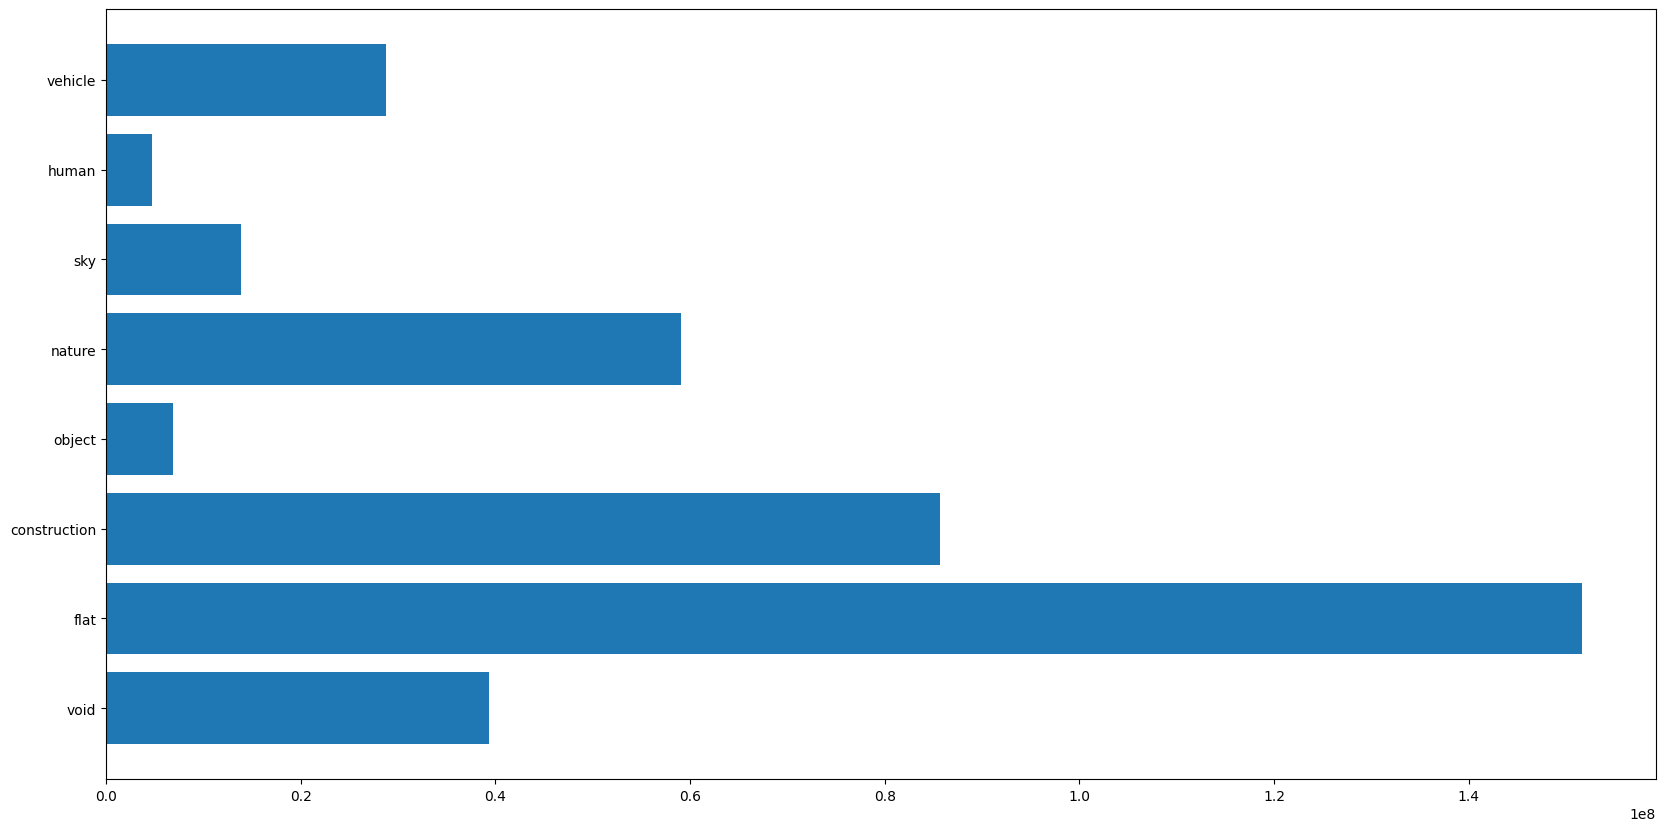

In [34]:
# Show a plot bar of the number of pixels per class
plt.figure(figsize=(20, 10))
plt.barh(counter.keys(), counter.values())
plt.yticks(
    list(counter.keys()),
    list(full_train_datagen.table_category2name.values()),
    rotation=0,
)
plt.show()

In [35]:
sample_weights = np.array(list(counter.values())) / np.sum(list(counter.values()))
assert np.isclose(np.sum(sample_weights), 1.0)

# 2. Les métriques de segmentation
----------------

## 2.1. Présentation des métriques

Afin de mesurer la performance de notre modèle de segmentation, nous allons utiliser les métriques suivantes:
- **La Pixel accuracy** qui est la métrique la plus simple et la plus intuitive. Elle mesure le nombre de pixels correctement prédits par le modèle.
- **La Mean Intersection over Union (mIoU)** qui est une métrique plus complexe qui mesure le chevauchement entre les prédictions et les vraies valeurs. Elle est calculée en prenant le rapport entre l'intersection et l'union des prédictions et des vraies valeurs.
- **La Dice coefficient** qui est une autre métrique, dont l'alias est le F1-score. Elle est calculée en prenant le rapport entre le double de l'intersection et la somme des prédictions et des vraies valeurs.


Je vais créér une classe DiceMetric héritant de `tf.keras.metrics.Metric` pour calculer le Dice coefficient, qui pourra être utilisée dans le modèle avec une fonction de perte personnalisée.<br>


La classe est personnalisée pour prendre une label **sparse**, soit une shape `(batch_size, H, W)` et une sortie produite par le modèle après une activation softmax qui contient un vecteur de probabilités pour chaque pixel et chaque classe sous une forme `(batch_size, H, W, num_classes)`.

In [36]:
class DiceMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, smooth=1e-5, name="dice_metric", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert the sparse y_true to one-hot encoding
        y_true_onehot = tf.one_hot(
            y_true, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Convert the y_pred probabilities with argmax
        y_pred_indices = tf.argmax(y_pred, axis=-1)  # (batch, h, w)
        # Convert the y_pred indices to one-hot encoding
        y_pred_onehot = tf.one_hot(
            y_pred_indices, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Flatten the one-hot tensors on all axes except batch
        y_true_flat = tf.reshape(
            y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)
        y_pred_flat = tf.reshape(
            y_pred_onehot, [tf.shape(y_pred_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)

        # Compute intersection and union for each class
        intersection = tf.reduce_sum(
            y_true_flat * y_pred_flat, axis=1
        )  # (batch, num_classes)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(
            y_pred_flat, axis=1
        )  # (batch, num_classes)

        # Compute DICE score for each class with the smoothening factor
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Compute the DICE mean score for each image
        dice_per_image = tf.reduce_mean(dice, axis=-1)  # (batch,)

        # Update the total dice and count with the mean dice score per image
        self.total_dice.assign_add(tf.reduce_sum(dice_per_image))
        self.count.assign_add(tf.cast(tf.size(dice_per_image), tf.float32))

    def result(self):
        # Compute the mean dice score over all images
        return self.total_dice / self.count

    def reset_states(self):
        # Reset the total dice and count at the end of each epoch
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

**Je passe à la création de ma liste de métriques moyennes:**

In [37]:
mean_metrics = [
    tf.keras.metrics.MeanIoU(
        num_classes=8,
        name="MeanIoU",
        dtype=None,
        ignore_class=None,  # Add Void if necessary
        sparse_y_true=True,  # As we are using sparse categorical crossentropy, the ground truth is sparse
        sparse_y_pred=False,  # As we are using softmax activation, the output is not sparse
        axis=-1,
    ),
    DiceMetric(num_classes=8, name="Dice"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="Pixel_Accuracy"),
]

**En supplément, je vais aussi suivre l'IoU par classe pour voir comment les modèles sont capables de gérer les déséquilibres de classses:**

In [38]:
per_class_metrics = [
    tf.keras.metrics.IoU(
        num_classes=8,
        target_class_ids=[i],  # Compute the IoU for the background class (class 0)
        name=f"IoU_class_{i}",
        sparse_y_true=True,
        sparse_y_pred=False,
        axis=-1,
    )
    for i in range(8)
]

## 2.3. Pistes d'amélioration concernant les métriques de segmentation

**Synthèse des grands principes du papier**  
📌 **Titre :** *A new metric for evaluating semantic segmentation: leveraging global and contour accuracy*  
✍️ **Auteurs :** Eduardo Fernandez-Moral, Renato Martins, Denis Wolf, Patrick Rives  
📅 **Source :** arXiv  https://www.irisa.fr/lagadic/pdf/2017_ppniv_fernandezmoral.pdf

---

**1️⃣ Contexte et Problématique**
La segmentation sémantique d'images est essentielle pour des applications en robotique mobile et en conduite autonome. Cependant, l'évaluation des performances des modèles de segmentation reste un défi, notamment en raison de la diversité des métriques utilisées. Les métriques existantes, comme l'IoU (Jaccard Index) ou la précision globale, ne capturent pas toujours correctement la qualité des contours, ce qui est crucial dans des contextes comme la navigation autonome.

---

**2️⃣ Contribution Principale**
Les auteurs proposent **une nouvelle métrique** qui intègre **la précision globale** et **la qualité des contours**, permettant une évaluation plus pertinente des modèles de segmentation.  

🔹 **Problème abordé :** Les métriques existantes présentent des résultats divergents et ne permettent pas toujours une comparaison efficace des modèles.  
🔹 **Solution proposée :** Une métrique hybride appelée **BJ (Boundary Jaccard)**, qui combine les avantages de l'index de Jaccard et des métriques basées sur les contours.  

---

**3️⃣ Revue des Métriques de Segmentation**
Les métriques traditionnelles évaluent la segmentation selon :  
✔ **La précision globale (Accuracy)** : rapport entre les pixels bien classés et le total.  
✔ **La précision par classe (Class-wise Precision)** : évaluation indépendante de chaque classe.  
✔ **L'index de Jaccard (IoU)** : rapport entre l'intersection et l'union des pixels classés correctement.  
✔ **La métrique BF (Boundary F1-score)** : évalue la précision des contours segmentés.  

**Limitation :**  
➡ Les métriques globales ne prennent pas en compte les contours, ce qui peut être problématique pour des classes minoritaires mais critiques (ex : piétons, feux de signalisation).  
➡ La métrique BF ne tient compte que des contours et peut ignorer la qualité de la segmentation globale.  

---

**4️⃣ Nouvelle métrique proposée : Boundary Jaccard (BJ)**
Les auteurs introduisent la **métrique BJ**, qui intègre :  
✅ **L'information globale** (nombre total de pixels bien classés).  
✅ **La qualité des contours** (distance entre les frontières du segment prédit et la vérité terrain).  

💡 **Pourquoi BJ est-elle plus efficace ?**  
✔ **Continue et stable** : contrairement à BF, elle ne dépend pas d'un seuil fixe.  
✔ **Intègre les pixels proches des contours** plutôt que seulement les frontières elles-mêmes.  
✔ **Facilite la comparaison entre modèles** en fournissant une seule valeur synthétique.  

---

**5️⃣ Expérimentation et Validation**
🔬 **Base de données utilisées** :  
- **Virtual KITTI** : images synthétiques de conduite autonome.  
- **KITTI** : données réelles de scènes urbaines.  

🖥 **Modèles testés** :  
- **SegNet** (réseau encodeur-décodeur classique).  
- **FuseNet** (fusion couleur et profondeur).  
- **CEDCNN** et **CEDCNN2** (variantes optimisées de SegNet).  

📊 **Résultats :**  
- **Les modèles intégrant des informations géométriques (profondeur, normales) sont plus performants.**  
- **CEDCNN2 (RGB+normales) obtient les meilleurs scores sur KITTI.**  
- **La métrique BJ est bien corrélée à IoU et BF, mais offre une meilleure stabilité et discrimination.**  

---

**6️⃣ Conclusion et Perspectives**
📌 **Apport principal** : Une métrique unifiée qui évalue à la fois la segmentation des pixels et la précision des contours.  
📌 **Impact** : Meilleure évaluation des modèles de segmentation, utile pour la robotique et la conduite autonome.  
📌 **Travaux futurs** : Optimisation des architectures CNN en intégrant BJ comme fonction de perte pour améliorer l’apprentissage.  

---

**🔎 Points Clés Retenus**
✔ **Problème** : Les métriques actuelles ne capturent pas la qualité des contours.  
✔ **Solution** : Une nouvelle métrique hybride BJ.  
✔ **Validation** : Expérimentation sur Virtual KITTI et KITTI.  
✔ **Impact** : Améliore la comparaison des modèles de segmentation sémantique.  

💡 **Conclusion :** Ce papier propose une avancée importante pour l’évaluation des modèles de segmentation, avec une approche plus robuste et pertinente dans des applications critiques comme la navigation autonome. 🚗💡

## 2.2. L'analyse et la visualisation des métriques

Je vais créer une classe `ModelMetric` pour gérer l'analyse et la visualisation des métriques.


Elle permets notamment de:
- Sauvegarder les historiques de métriques d'entraînement et de test par expérience
- Produire des visualisations pour:
    - Analyse de l'évolution de la perte lors de l'entraînement
    - Analyse de l'évolution des métriques lors de l'entraînement
    - Analyse des métriques sur l'évaluation du modèle sur le jeu de test

In [39]:
class ModelMetric:
    def __init__(
        self,
        history: callbacks.history.History,
        results: dict,
        extra_metrics: dict,
        monitor: str,
        best_monitor: str,
    ):
        """ """
        self.history_metrics = {
            (f"train_{k}" if not k.startswith("val") else k): v
            for k, v in history.history.items()
        }
        self.history_params = history.params
        self.epochs_list = history.epoch
        self.model_name = history._model.name
        self.results = results
        self.extra_metrics = extra_metrics
        self.monitor = monitor
        self.best_monitor = best_monitor

    @classmethod
    def from_pickle(
        cls,
        pickle_path: str,
    ):
        with open(pickle_path, "rb") as f:
            return pickle.load(f)

    @property
    def best_epoch(self):
        # Take the epoch with the best validation loss
        match self.best_monitor.lower().strip():
            case "max":
                return self.history_metrics[self.monitor].index(
                    max(self.history_metrics[self.monitor])
                )
            case "min":
                return self.history_metrics[self.monitor].index(
                    min(self.history_metrics[self.monitor])
                )
            case _:
                raise ValueError(
                    f"Unknown monitor: {self.monitor}. Must be 'max' or 'min'."
                )

    @cached_property
    def metrics_df(self):
        # Create a DataFrame with the best epoch metrics
        train_val_metrics = (
            pd.DataFrame(self.history_metrics)
            .iloc[self.best_epoch, :]
            .to_frame()
            .T.reset_index(drop=True)
        )
        test_metrics = pd.DataFrame(
            data=[self.results.values()],
            columns=[f"test_{k}" for k in self.results.keys()],
        )
        metrics_df = pd.concat([train_val_metrics, test_metrics], axis=1)
        metrics_df = metrics_df.assign(
            best_epoch=self.best_epoch,
            n_epochs=self.history_params.get("epochs"),
            n_steps=self.history_params.get("steps"),
            model_name=self.model_name,
        )
        metrics_df.insert(
            0, "experiment_folder", self.extra_metrics.get("experiment_folder")
        )
        for key, value in self.extra_metrics.items():
            if key != "experiment_folder":
                metrics_df[key] = value
        return metrics_df

    def save_metrics(
        self, metrics_path: str = "../metrics.csv", artifacts_path: str = "../artifacts"
    ):
        # Save metrics as a CSV file if it does not exist
        if not os.path.exists(metrics_path):
            self.metrics_df.to_csv(metrics_path, mode="a", header=True, index=False)
            print(f"Metrics file created at {metrics_path}")
        # Else, append the metrics to the existing file
        else:
            self.metrics_df.to_csv(metrics_path, mode="a", header=False, index=False)
            print(f"Metrics file updated at {metrics_path}")

        # Save model_metric as a pickle file
        with open(
            f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/model_metric.pkl",
            "wb",
        ) as f:
            pickle.dump(self, f)
            print(f"Pickle file created at {artifacts_path}")

    def plot_loss(self, figsize=(12, 6), artifacts_path: str = "../artifacts"):
        fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_loss.png"
        # Plot the training and validation loss
        fig = plt.figure(figsize=figsize)
        plt.plot(
            self.epochs_list,
            self.history_metrics["train_loss"],
            label="train_loss",
            color="blue",
        )
        plt.plot(
            self.epochs_list,
            self.history_metrics["val_loss"],
            label="val_loss",
            color="red",
        )
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"{self.model_name} Training and Validation Loss Curve per epoch")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid()
        plt.legend()
        plt.show()
        fig.savefig(fig_path)

    def plot_train_metrics(
        self, figsize=(20, 10), artifacts_path: str = "../artifacts"
    ):
        fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_train_metrics.png"
        history_metrics_df = pd.DataFrame(self.history_metrics)
        fig, ax = plt.subplots(
            2, 2, figsize=figsize, sharex=True, sharey=True, tight_layout=True
        )
        fig.suptitle(f"{self.model_name} Training Metrics Curve per epoch", fontsize=16)
        for i, split in enumerate(("train", "val")):
            history_metrics_df.filter(
                [
                    col
                    for col in self.history_metrics.keys()
                    if col.startswith(f"{split}")
                    and "loss" not in col
                    and "class" not in col
                ]
            ).plot(ax=ax[0, i], title=f"{split} mean metrics", grid=True).legend(
                bbox_to_anchor=(1.0, 1.0)
            )
        for i, split in enumerate(("train", "val")):
            history_metrics_df.filter(
                [
                    col
                    for col in self.history_metrics.keys()
                    if col.startswith(f"{split}_IoU") and "loss" not in col
                ]
            ).plot(ax=ax[1, i], title=f"{split} per class metrics", grid=True).legend(
                bbox_to_anchor=(1.0, 1.0)
            )
        plt.show()
        fig.savefig(fig_path)

    def plot_test_metrics(self, figsize=(20, 10), artifacts_path: str = "../artifacts"):
        # fig_path = f"{artifacts_path}/{self.extra_metrics.get('experiment_folder')}/plot_test_metrics.png"
        pass

In [40]:
class ComparativeMetric:
    def __init__(self, path="../metrics.csv"):
        self.metrics_df = pd.read_csv(path).drop_duplicates(keep="last")

# 3. L'architecture UNET
----------------

## 3.1. Présentation

**Analyse du document : "U-Net: Convolutional Networks for Biomedical Image Segmentation"**

Le document **"U-Net: Convolutional Networks for Biomedical Image Segmentation"** de **Olaf Ronneberger, Philipp Fischer et Thomas Brox** présente une architecture de réseau de neurones convolutifs spécialisée dans la segmentation d'images biomédicales. Cette méthode repose sur une approche en **forme de U**, permettant à la fois l'extraction des caractéristiques contextuelles et une localisation précise.

---

**🔍 Résumé et points clés du document**

**1️⃣ Contexte et motivation**
- La segmentation d'images biomédicales est essentielle pour diverses applications (analyse cellulaire, identification de structures neuronales, etc.).
- Les réseaux neuronaux convolutifs (CNN) ont prouvé leur efficacité dans la classification d’images, mais la segmentation requiert une approche différente.
- **Problèmes des approches existantes** :
  - Les réseaux CNN traditionnels traitent les images pixel par pixel (comme le modèle de Ciresan et al.), ce qui est inefficace.
  - Le compromis entre la localisation précise et l'utilisation du contexte reste un défi.

**2️⃣ Description de l’architecture U-Net**
- L'architecture est composée de **deux chemins** :
  1. **Chemin contractant** (Encoder) : Extraction des caractéristiques via des convolutions 3x3 suivies de max-pooling.
  2. **Chemin expansif** (Decoder) : Restauration de la résolution de l’image grâce à des opérations d’**up-convolution**.
- Les connexions **skip connections** permettent de récupérer les détails de l’image tout en maintenant une bonne compréhension du contexte global.
- Le réseau ne contient **aucune couche complètement connectée**, ce qui le rend compatible avec des images de taille variable.

**3️⃣ Stratégies d’apprentissage et d’optimisation**
- **Augmentation de données** : Application de transformations élastiques pour compenser le manque d'images annotées.
- **Fonction de coût** : Utilisation d’une fonction d’entropie croisée pondérée pour donner plus d’importance aux frontières entre objets.
- **Stratégie de tuile ("overlap-tile strategy")** : Permet de traiter des images de grande taille sans limitation par la mémoire GPU.

**4️⃣ Expérimentations et résultats**
- **Segmentation neuronale en microscopie électronique** : Le modèle U-Net a surpassé l’approche de Ciresan et al. sur la compétition ISBI 2012 avec un **"warping error" de 0.0003529**.
- **Suivi de cellules en microscopie optique** :
  - **Données PhC-U373** : Intersection-over-Union (**IoU**) de **92%**, meilleure performance comparée au modèle précédent (83%).
  - **Données DIC-HeLa** : IoU de **77.5%**, contre **46%** pour la meilleure approche concurrente.

**5️⃣ Conclusions et impact**
- **Avantages** :
  - **Performance élevée** même avec peu d’images annotées.
  - **Généralisation** à diverses applications biomédicales.
  - **Temps d'entraînement raisonnable** (~10 heures sur un GPU NVidia Titan).
- **Limites** :
  - Bien que le modèle soit performant, il nécessite une forte puissance de calcul pour l’inférence sur des images de grande taille.
  - L'amélioration des séparations entre objets reste un défi.

---

**🧐 Analyse critique et perspectives**

**✔️ Points positifs**

✅ L'architecture U-Net est un modèle révolutionnaire qui a ouvert la voie à de nombreuses avancées en vision par ordinateur appliquée au domaine médical.  
✅ L'accent mis sur **l’augmentation de données** permet un apprentissage efficace même avec un petit jeu de données.  
✅ Le modèle est **rapide et efficace**, facilitant son adoption dans la communauté scientifique et médicale.  

**❌ Limites et pistes d’amélioration**
🔸 L’entraînement du modèle reste coûteux en ressources, nécessitant un GPU performant.  
🔸 Les performances pourraient être améliorées avec des techniques modernes comme **l'attention mécanisme** ou des architectures plus récentes (**Transformers** pour la segmentation).  
🔸 L’U-Net fonctionne très bien sur des images en 2D, mais pour des volumes 3D (IRM, scanner), des variantes comme le **3D U-Net** sont nécessaires.  

## 3.2. Implémentation du modèle

In [41]:
def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x


def decoder_block(inputs, skip_features, num_filters):
    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        inputs
    )

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = ResizeSkipFeatures()([x, skip_features])
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x


class ResizeSkipFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        x, skip_features = inputs
        return tf.image.resize(skip_features, size=(tf.shape(x)[1], tf.shape(x)[2]))


def unet_model(input_shape=(256, 512, 3), num_classes=8, name="u-net"):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(
        num_classes, 1, padding="same", activation="softmax"
    )(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name=name)
    return model

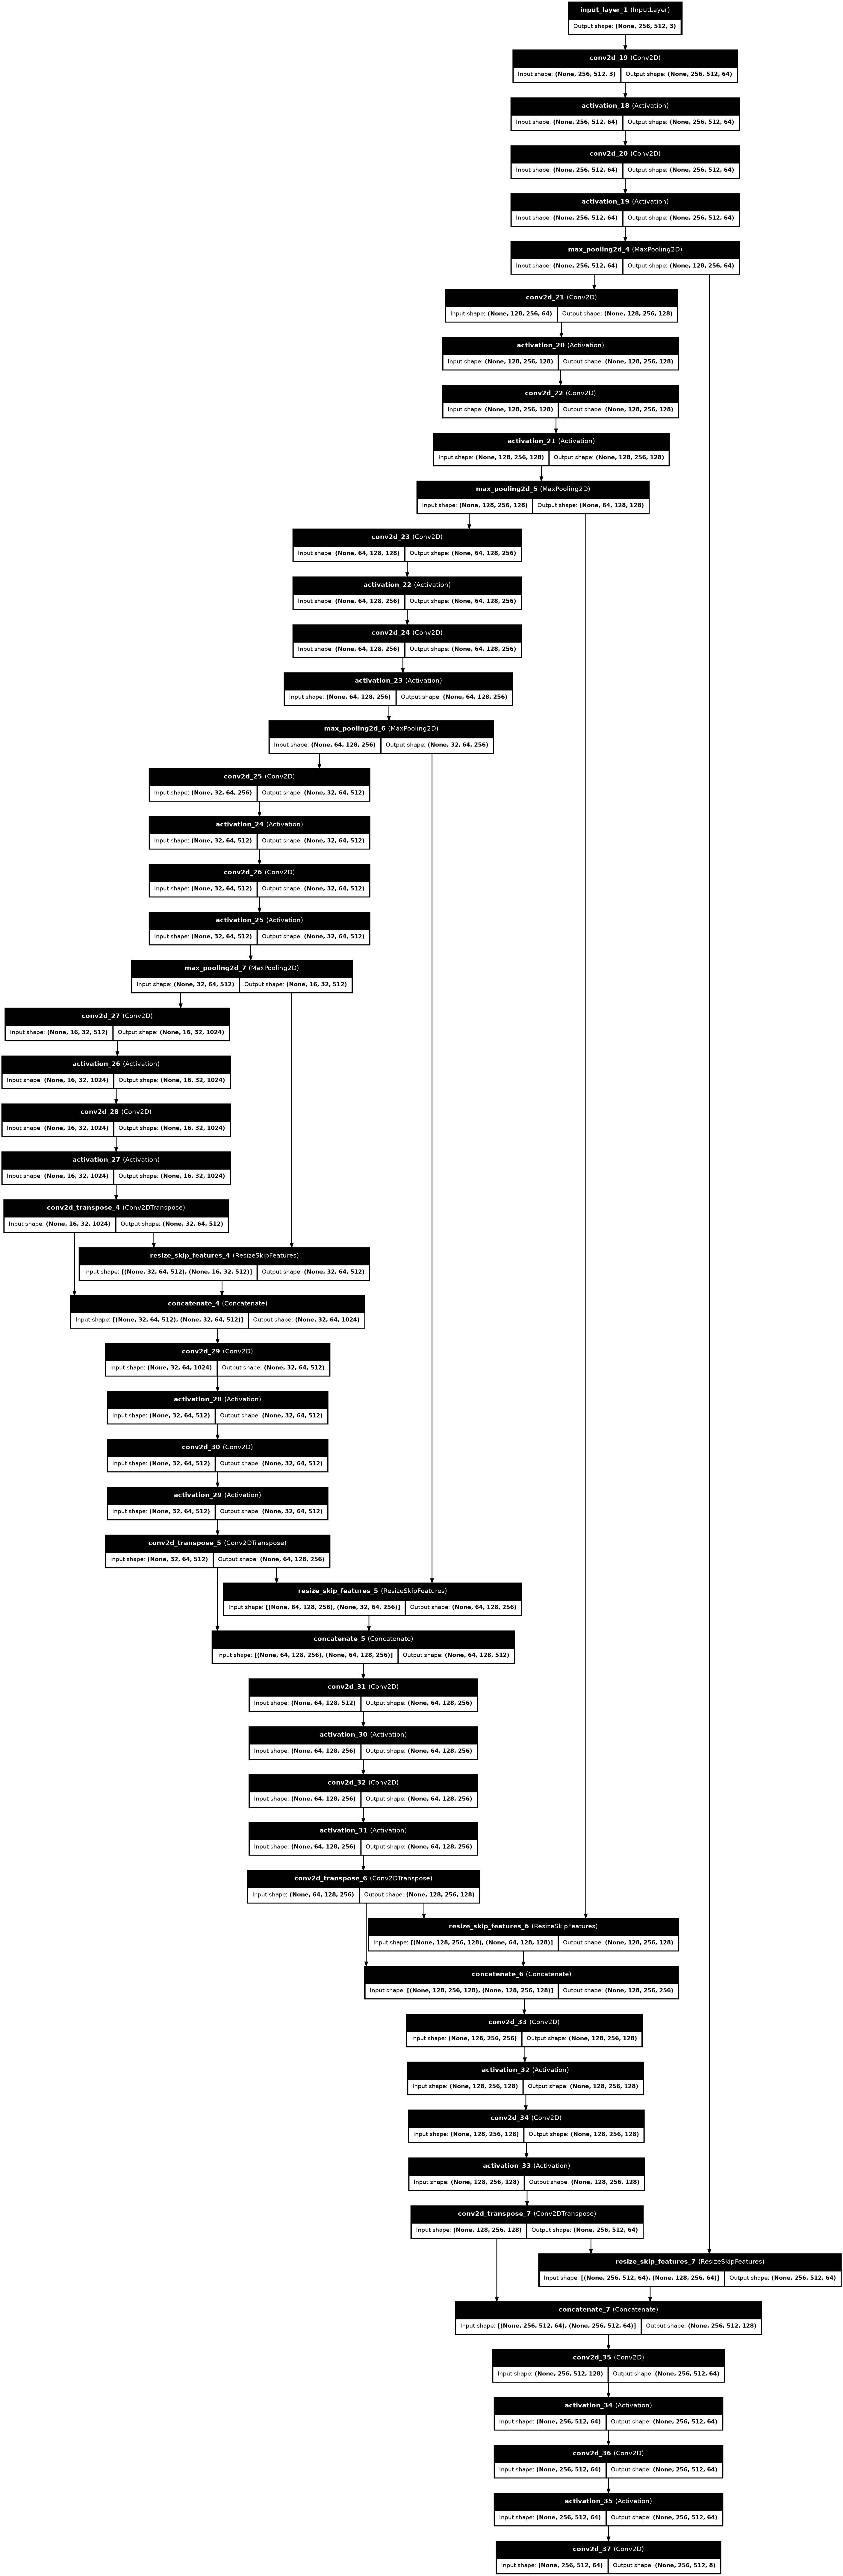

In [42]:
tf.keras.utils.plot_model(
    unet_model(),
    "model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

# 4. Les fonctions de perte dans la segmentation

Présentice DiceLoss, SCCELoss, FocalLoss

In [43]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, from_logits=False, smooth=1e-6, name="dice_loss"):
        """
        Dice Loss pour segmentation multi-classe.

        Args:
            num_classes (int): Nombre de classes dans la segmentation.
            from_logits (bool): Si True, applique `softmax` avant le calcul.
            smooth (float): Facteur de lissage pour éviter la division par zéro.
            name (str): Nom de la loss.
        """
        super().__init__(name=name)
        self.num_classes = num_classes
        self.from_logits = from_logits
        self.smooth = smooth

    def call(self, y_true, y_pred):
        """
        Calcul de la perte Dice.

        Args:
            y_true (tensor): Vraies étiquettes (batch, H, W) ou (batch, H, W, C).
            y_pred (tensor): Prédictions (batch, H, W, C).

        Returns:
            Tensor: Dice Loss
        """
        # Convertir y_true en one-hot si nécessaire
        if tf.shape(y_true).shape == 3:  # (batch, H, W) → (batch, H, W, C)
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)

        if self.from_logits:
            y_pred = tf.nn.softmax(
                y_pred, axis=-1
            )  # Conversion des logits en probabilités

        # Calcul de l'intersection et de l'union pour chaque classe
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

        dice_score = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Moyenne sur toutes les classes
        return 1 - tf.reduce_mean(dice_score, axis=-1)


In [44]:
# Create a class from tf.keras.losses.Loss combining dice loss and sparse categorical crossentropy
class DiceCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        num_classes,
        from_logits=False,
        smooth=1e-6,
        alpha=0.7,
        name="dice_crossentropy_loss",
    ):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.alpha = alpha

    def call(self, y_true, y_pred):
        # Compute the dice loss
        dice_loss = DiceLoss(
            num_classes=self.num_classes,
            from_logits=self.from_logits,
            smooth=self.smooth,
        )(y_true, y_pred)
        # Compute the sparse categorical crossentropy loss
        scce_loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=self.from_logits
        )(y_true, y_pred)
        # Return the sum of both losses weighted by alpha
        return self.alpha * dice_loss + (1 - self.alpha) * scce_loss

In [45]:
def _focal_loss(y_true, y_pred, gamma=2.0):
    scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    weights = tf.pow(
        1 - tf.exp(-scce), gamma
    )  # Réduit la perte sur les classes dominantes
    return tf.reduce_mean(weights * scce)


In [46]:
# Create a class from tf.keras.losses.Loss combining dice loss and focal loss
class DiceFocalLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        num_classes,
        from_logits=False,
        smooth=1e-6,
        alpha=0.7,
        gamma=2.0,
        name="dice_focal_loss",
    ):
        super().__init__(name=name)
        self.num_classes = num_classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Compute the dice loss
        dice_loss = DiceLoss(
            num_classes=self.num_classes,
            from_logits=self.from_logits,
            smooth=self.smooth,
        )(y_true, y_pred)
        # Compute the focal loss
        focal_loss = SparseCategoricalFocalLoss(
            gamma=self.gamma,
            from_logits=self.from_logits,
            name="sparse_categorical_focal_loss",
        )(y_true, y_pred)
        # Return the sum of both losses
        return self.alpha * dice_loss + (1 - self.alpha) * focal_loss

# 5. UNET From Sratch

## 5.0. SCCE Loss

In [26]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
# Create the model
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

# Folder to create to store artifacts
new_folder = 50

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=5,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,  # Set to False if y_pred is a probability distribution
    name="sparse_categorical_crossentropy",
)

# Define the optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

# Train the model
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping],
)

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 3567s 24s/step - Dice: 0.1578 - IoU_class_0: 0.1145 - IoU_class_1: 0.4236 - IoU_class_2: 0.1045 - IoU_class_3: 0.0053 - IoU_class_4: 0.0738 - IoU_class_5: 0.0746 - IoU_class_6: 0.0116 - IoU_class_7: 0.0427 - MeanIoU: 0.1063 - Pixel_Accuracy: 0.4144 - loss: 1.8265 - val_Dice: 0.3956 - val_IoU_class_0: 0.3779 - val_IoU_class_1: 0.7333 - val_IoU_class_2: 0.4198 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.1754 - val_IoU_class_5: 0.5086 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.1994 - val_MeanIoU: 0.3018 - val_Pixel_Accuracy: 0.6478 - val_loss: 1.0061
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 3539s 24s/step - Dice: 0.4477 - IoU_class_0: 0.4476 - IoU_class_1: 0.7709 - IoU_class_2: 0.4342 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.3977 - IoU_class_5: 0.6026 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.2077 - MeanIoU: 0.3576 - Pixel_Accuracy: 0.6884 - loss: 0.8922 - val_Dice: 0.5077 - val_IoU_class_0: 0.4869 - val_IoU_class_1: 0.8113 - val_Io

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/50/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

32/32 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - Dice: 0.6312 - IoU_class_0: 0.6754 - IoU_class_1: 0.9082 - IoU_class_2: 0.6905 - IoU_class_3: 0.0323 - IoU_class_4: 0.7715 - IoU_class_5: 0.7720 - IoU_class_6: 0.2805 - IoU_class_7: 0.6671 - MeanIoU: 0.5997 - Pixel_Accuracy: 0.8617 - loss: 0.4263


In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/50/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

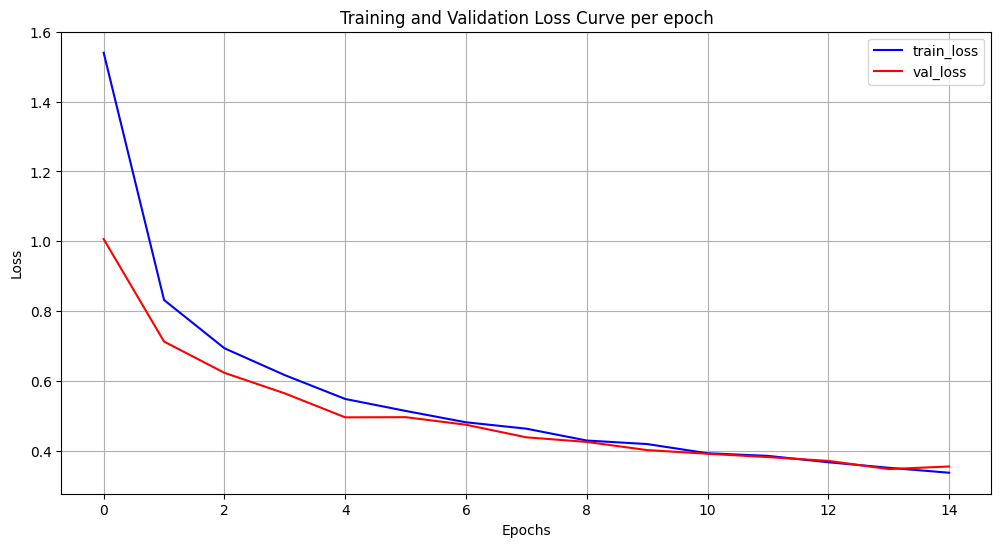

In [143]:
model_metric.plot_loss()

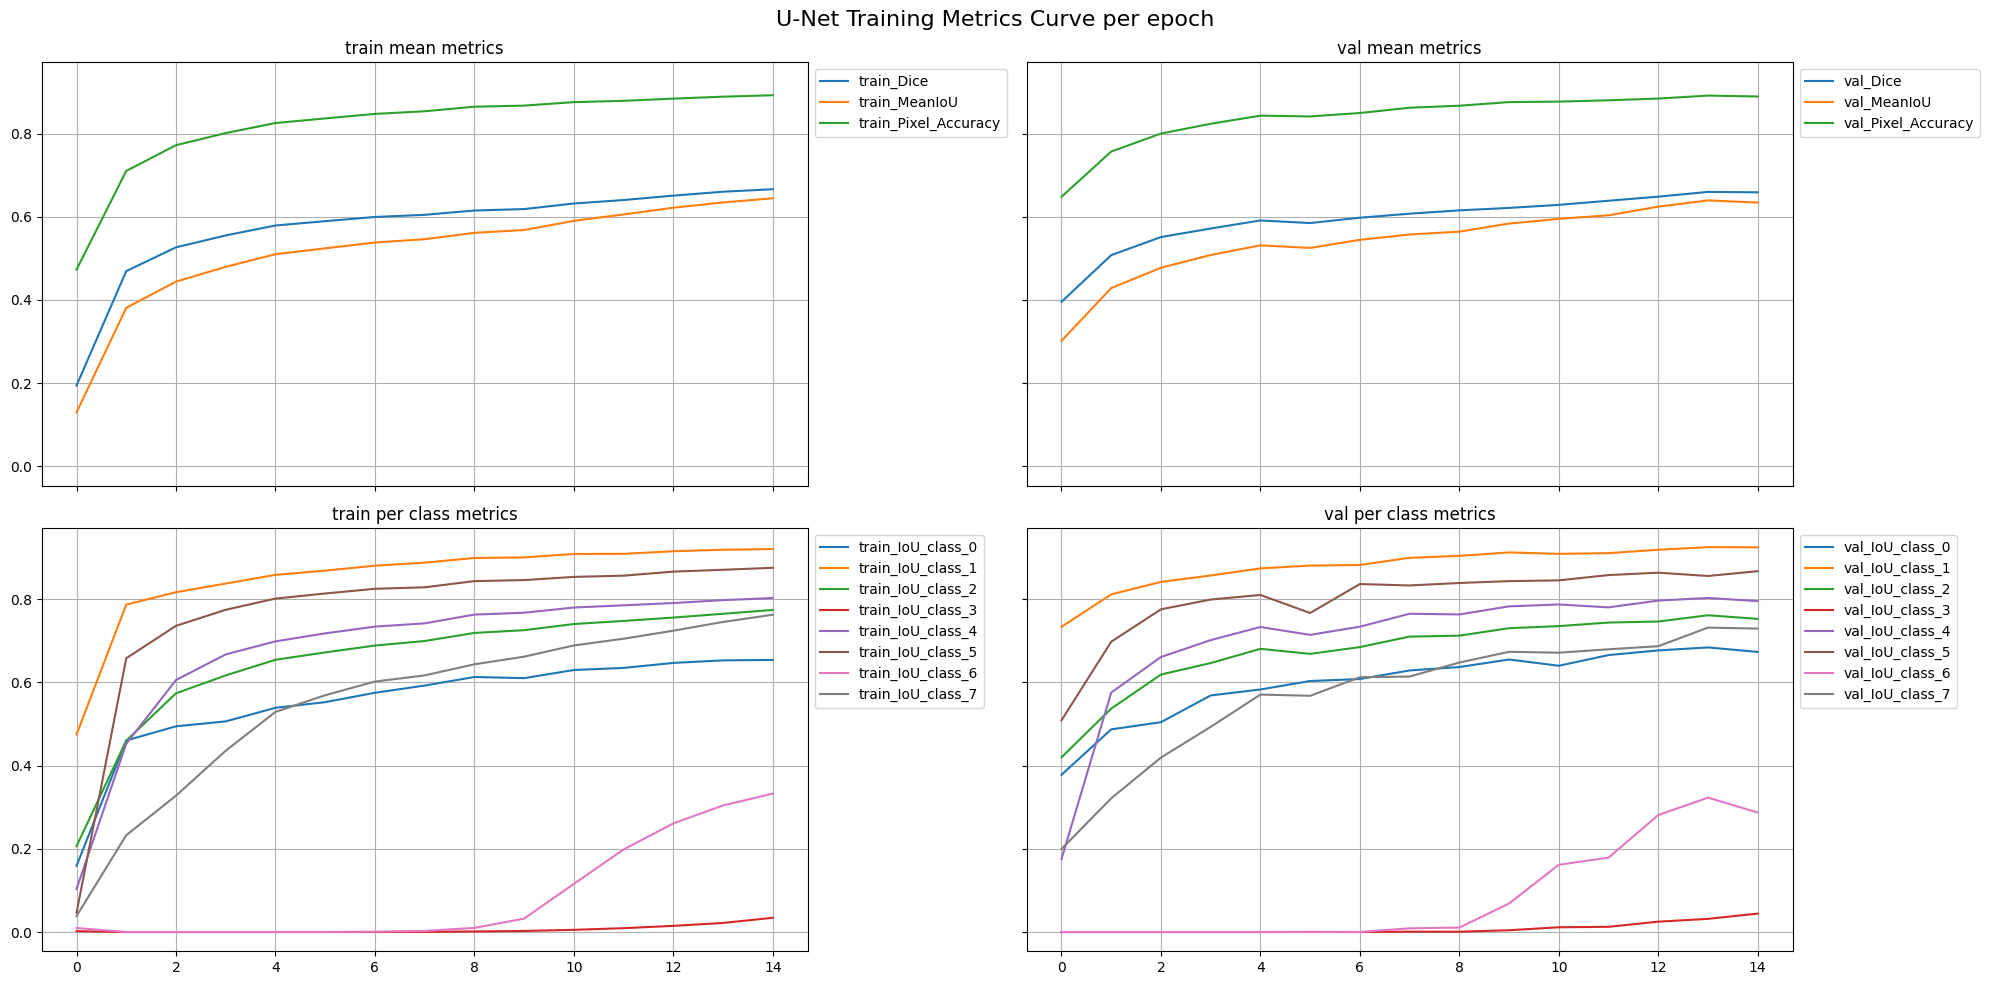

In [144]:
model_metric.plot_train_metrics()

<Axes: >

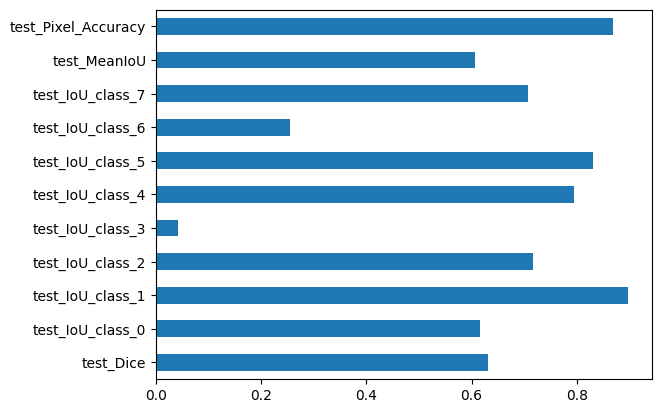

In [155]:
model_metric.metrics_df.filter(like="test", axis=1).T[:-2].plot(
    kind="barh", legend=False
)

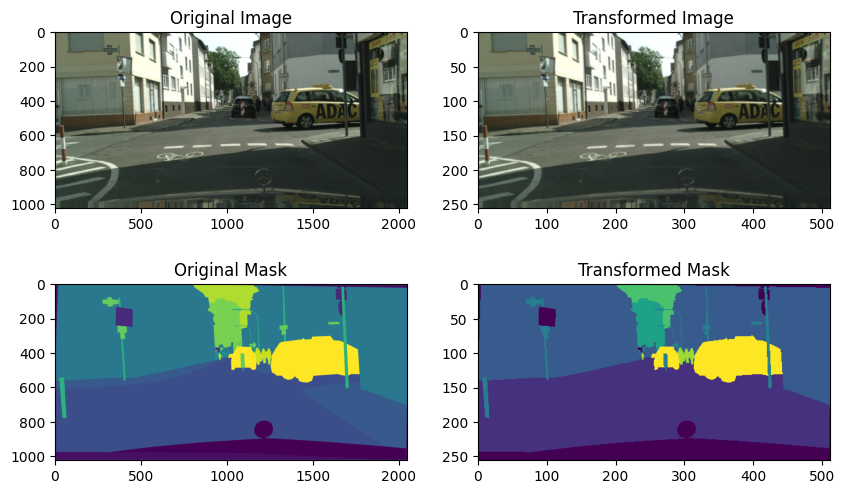

In [43]:
test_datagen.show_transformation(index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


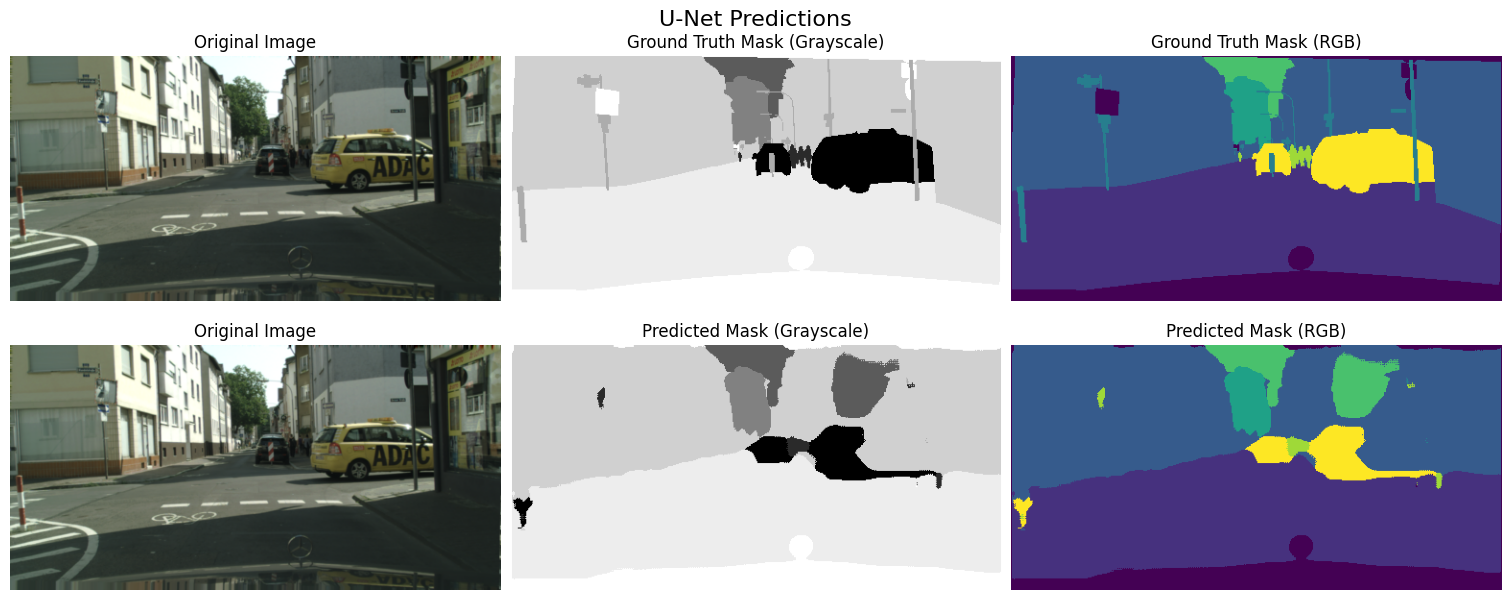

In [44]:
test_datagen.show_prediction(model=model, index=0)

## 5.1 SCCE Loss weighted

In [147]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=True,
    sample_weights=sample_weights,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
# Create the model
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

# Folder to create to store artifacts
new_folder = 51

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=5,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,  # Set to False if y_pred is a probability distribution
    name="sparse_categorical_crossentropy",
)

# Define the optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

# Train the model
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping],
)

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 3567s 24s/step - Dice: 0.1578 - IoU_class_0: 0.1145 - IoU_class_1: 0.4236 - IoU_class_2: 0.1045 - IoU_class_3: 0.0053 - IoU_class_4: 0.0738 - IoU_class_5: 0.0746 - IoU_class_6: 0.0116 - IoU_class_7: 0.0427 - MeanIoU: 0.1063 - Pixel_Accuracy: 0.4144 - loss: 1.8265 - val_Dice: 0.3956 - val_IoU_class_0: 0.3779 - val_IoU_class_1: 0.7333 - val_IoU_class_2: 0.4198 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.1754 - val_IoU_class_5: 0.5086 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.1994 - val_MeanIoU: 0.3018 - val_Pixel_Accuracy: 0.6478 - val_loss: 1.0061
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 3539s 24s/step - Dice: 0.4477 - IoU_class_0: 0.4476 - IoU_class_1: 0.7709 - IoU_class_2: 0.4342 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.3977 - IoU_class_5: 0.6026 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.2077 - MeanIoU: 0.3576 - Pixel_Accuracy: 0.6884 - loss: 0.8922 - val_Dice: 0.5077 - val_IoU_class_0: 0.4869 - val_IoU_class_1: 0.8113 - val_Io

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/51/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

32/32 ━━━━━━━━━━━━━━━━━━━━ 180s 6s/step - Dice: 0.6312 - IoU_class_0: 0.6754 - IoU_class_1: 0.9082 - IoU_class_2: 0.6905 - IoU_class_3: 0.0323 - IoU_class_4: 0.7715 - IoU_class_5: 0.7720 - IoU_class_6: 0.2805 - IoU_class_7: 0.6671 - MeanIoU: 0.5997 - Pixel_Accuracy: 0.8617 - loss: 0.4263


In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/51/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

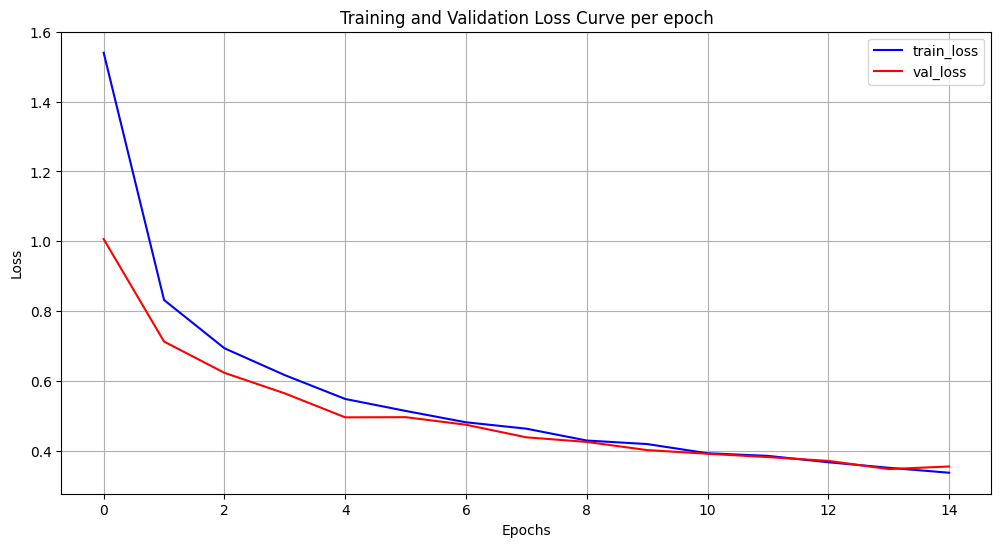

In [ ]:
model_metric.plot_loss()

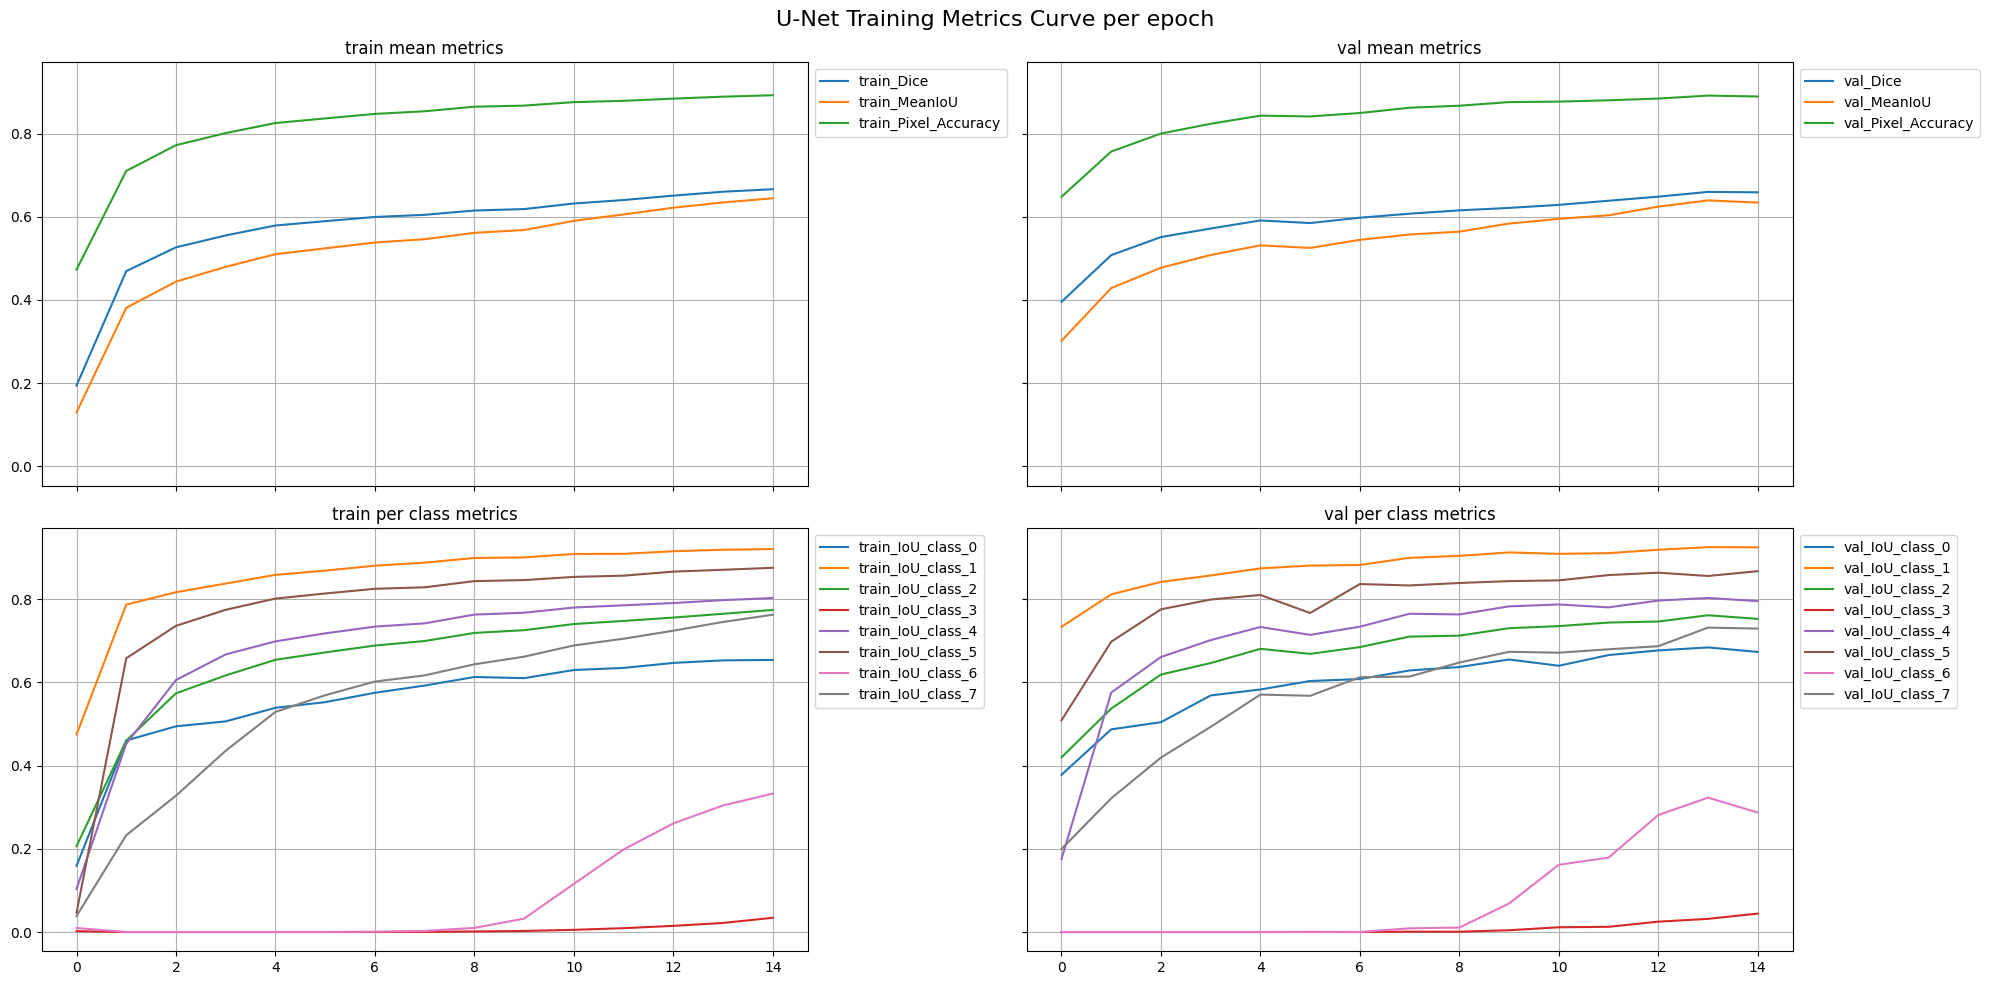

In [ ]:
model_metric.plot_train_metrics()

<Axes: >

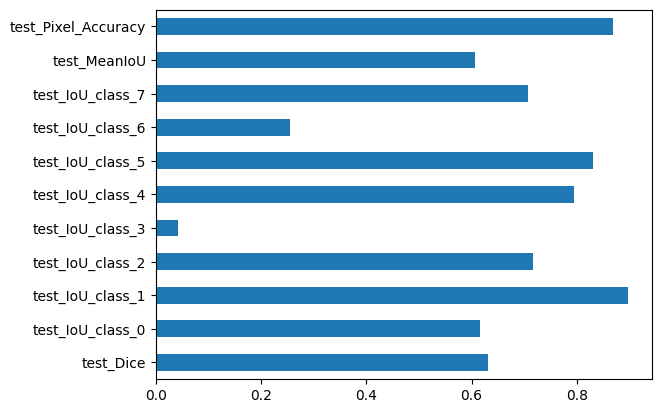

In [ ]:
model_metric.metrics_df.filter(like="test", axis=1).T[:-2].plot(
    kind="barh", legend=False
)

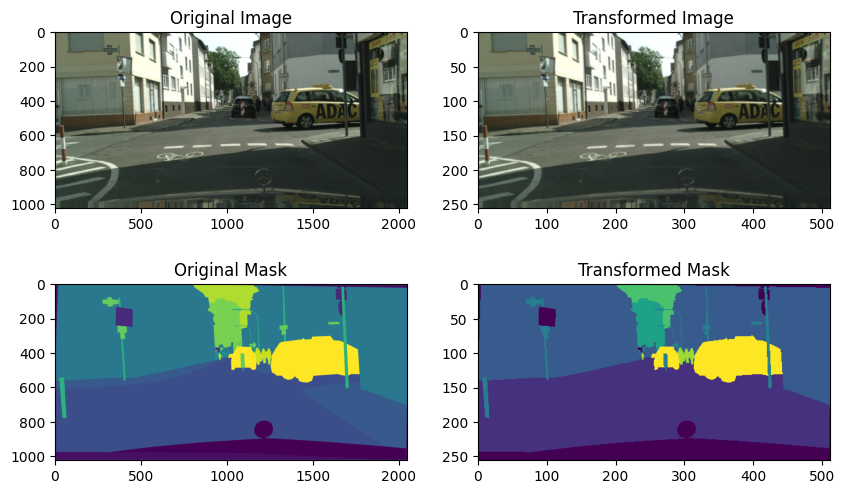

In [ ]:
test_datagen.show_transformation(index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


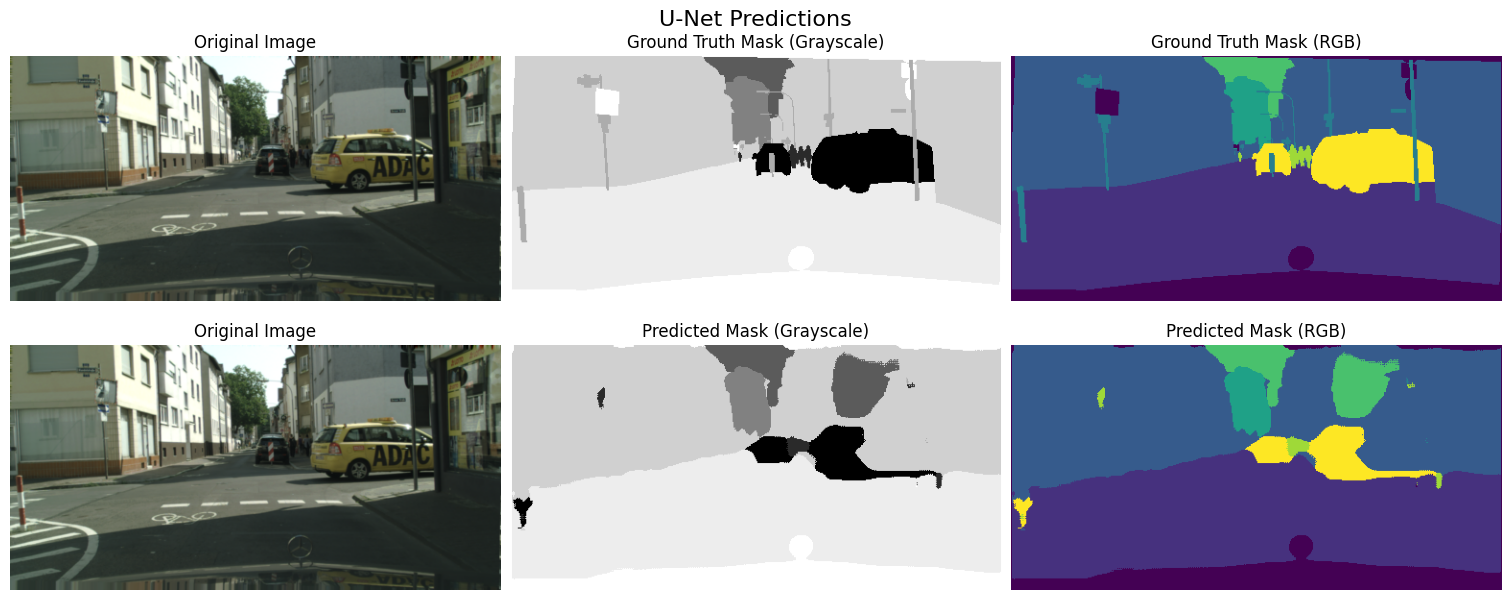

In [ ]:
test_datagen.show_prediction(model=model, index=0)

## 5.2. DiceLoss & SCCE

In [141]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
# Create the model
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

# Folder to create to store artifacts
new_folder = 52

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=5,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Define the loss function
loss_fn = DiceCrossEntropyLoss(
    num_classes=train_datagen.num_classes,
    from_logits=False,
    smooth=1e-6,
    alpha=0.7,
    name="dice_crossentropy_loss",
)


# Define the optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

# Train the model
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping],
)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 3754s 25s/step - Dice: 0.3283 - IoU_class_0: 0.2668 - IoU_class_1: 0.5315 - IoU_class_2: 0.3346 - IoU_class_3: 0.0651 - IoU_class_4: 0.3414 - IoU_class_5: 0.2193 - IoU_class_6: 0.1766 - IoU_class_7: 0.2732 - MeanIoU: 0.2761 - Pixel_Accuracy: 0.5833 - loss: 1.1358 - val_Dice: 0.4189 - val_IoU_class_0: 0.2979 - val_IoU_class_1: 0.8037 - val_IoU_class_2: 0.3634 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.4170 - val_IoU_class_5: 0.5451 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.1958 - val_MeanIoU: 0.3279 - val_Pixel_Accuracy: 0.6670 - val_loss: 0.7614
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 3705s 25s/step - Dice: 0.4521 - IoU_class_0: 0.4139 - IoU_class_1: 0.8073 - IoU_class_2: 0.4324 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.4364 - IoU_class_5: 0.6254 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.2364 - MeanIoU: 0.3690 - Pixel_Accuracy: 0.6978 - loss: 0.7118 - val_Dice: 0.4923 - val_IoU_class_0: 0.4127 - val_IoU_class_1: 0.8248 - val_Io

KeyboardInterrupt: 

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/52/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

15


In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/52/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

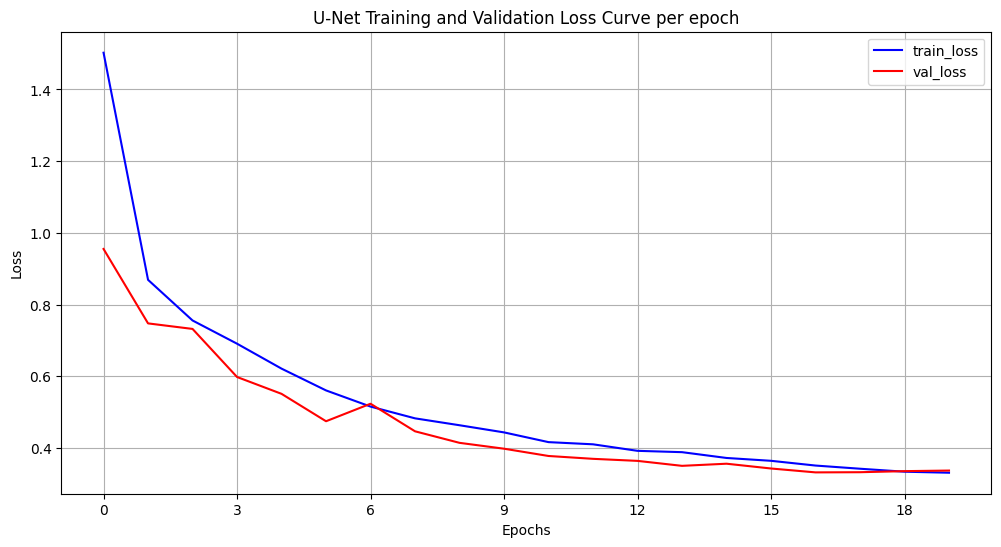

In [68]:
model_metric.plot_loss()

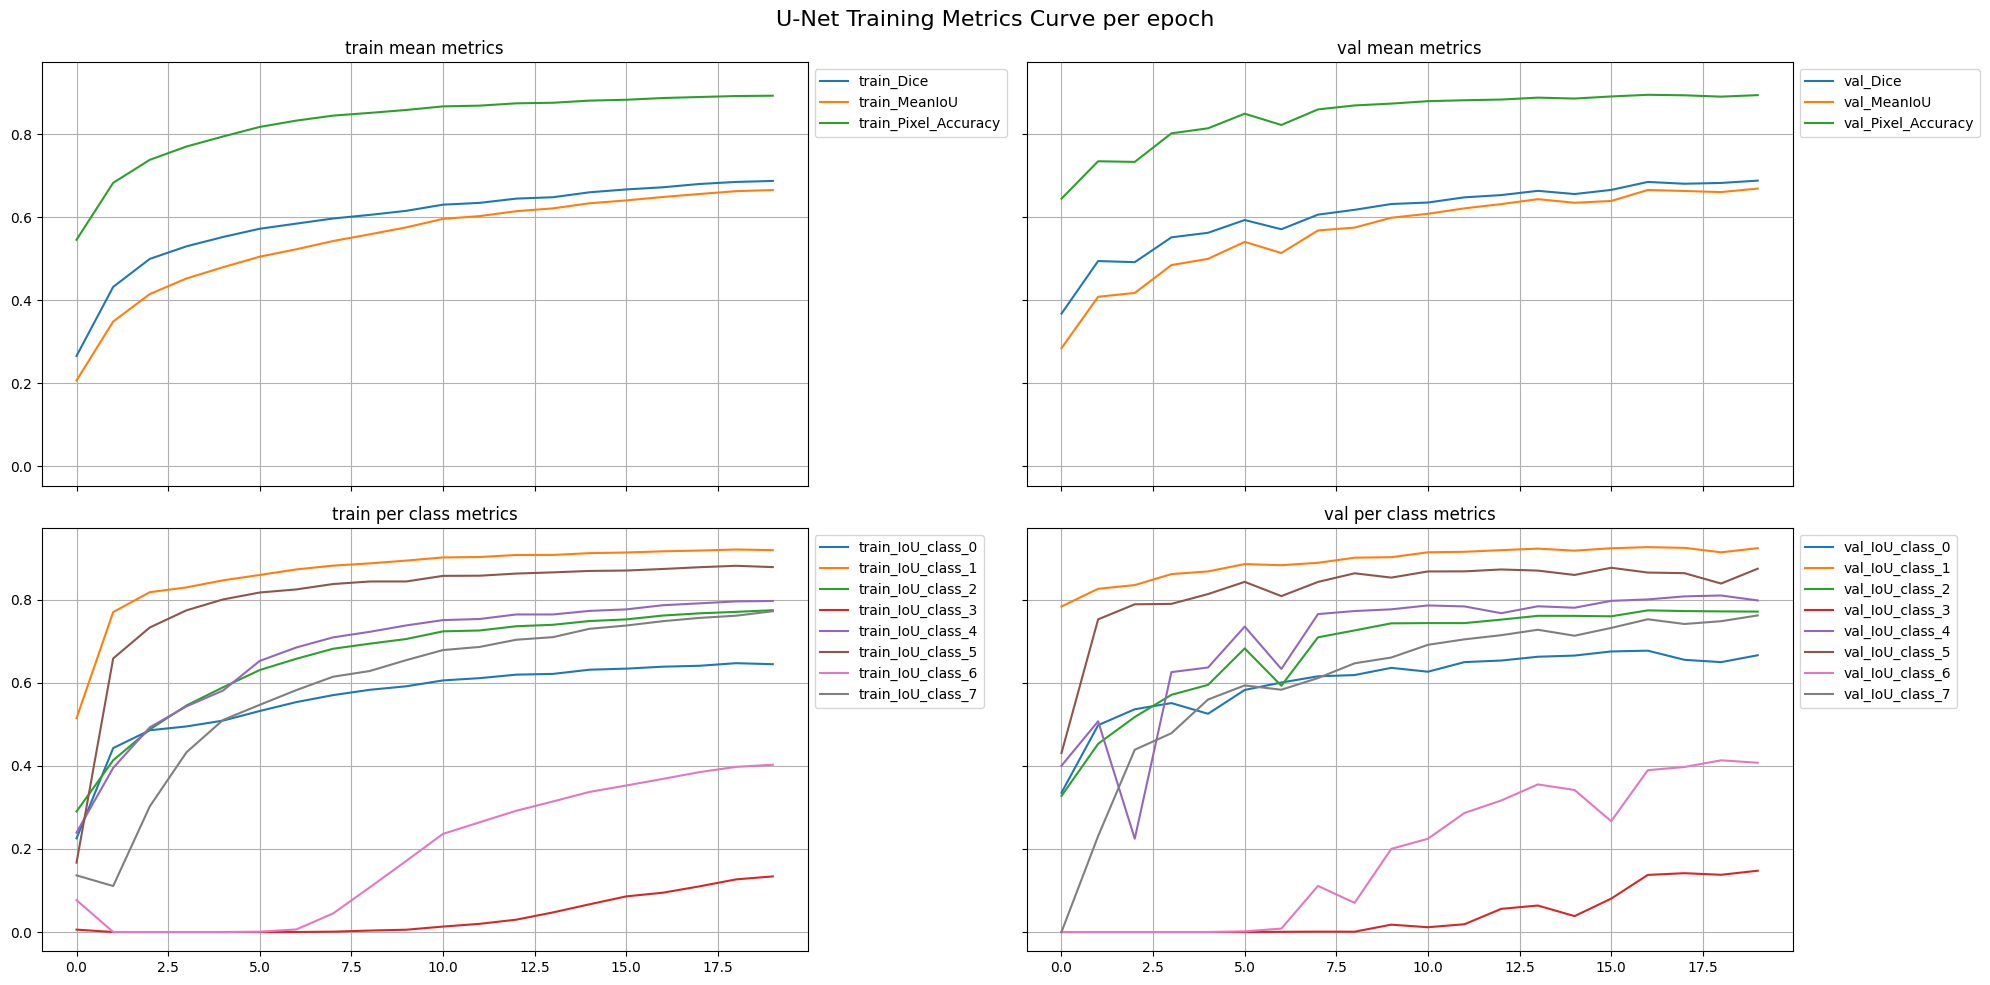

In [69]:
model_metric.plot_train_metrics()

<Axes: >

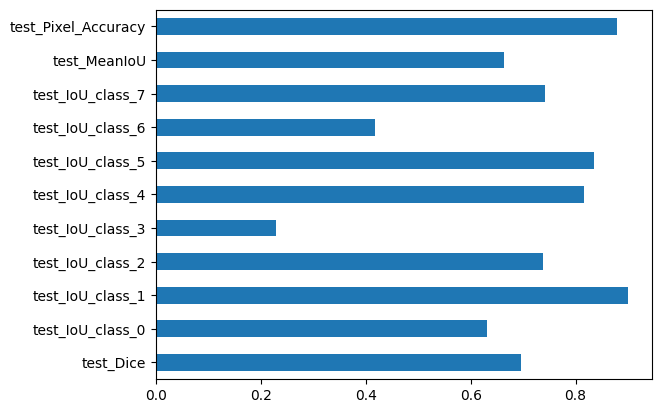

In [70]:
model_metric.metrics_df.filter(like="test", axis=1).T[:-2].plot(
    kind="barh", legend=False
)

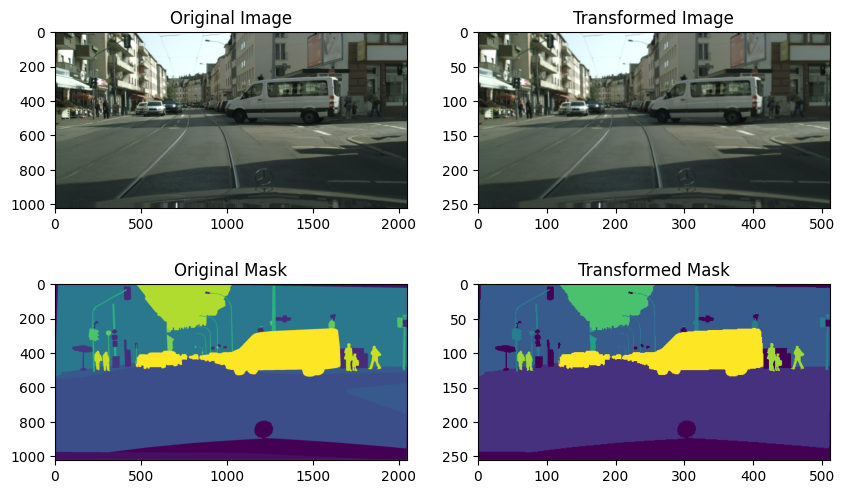

In [144]:
test_datagen.show_transformation(index=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


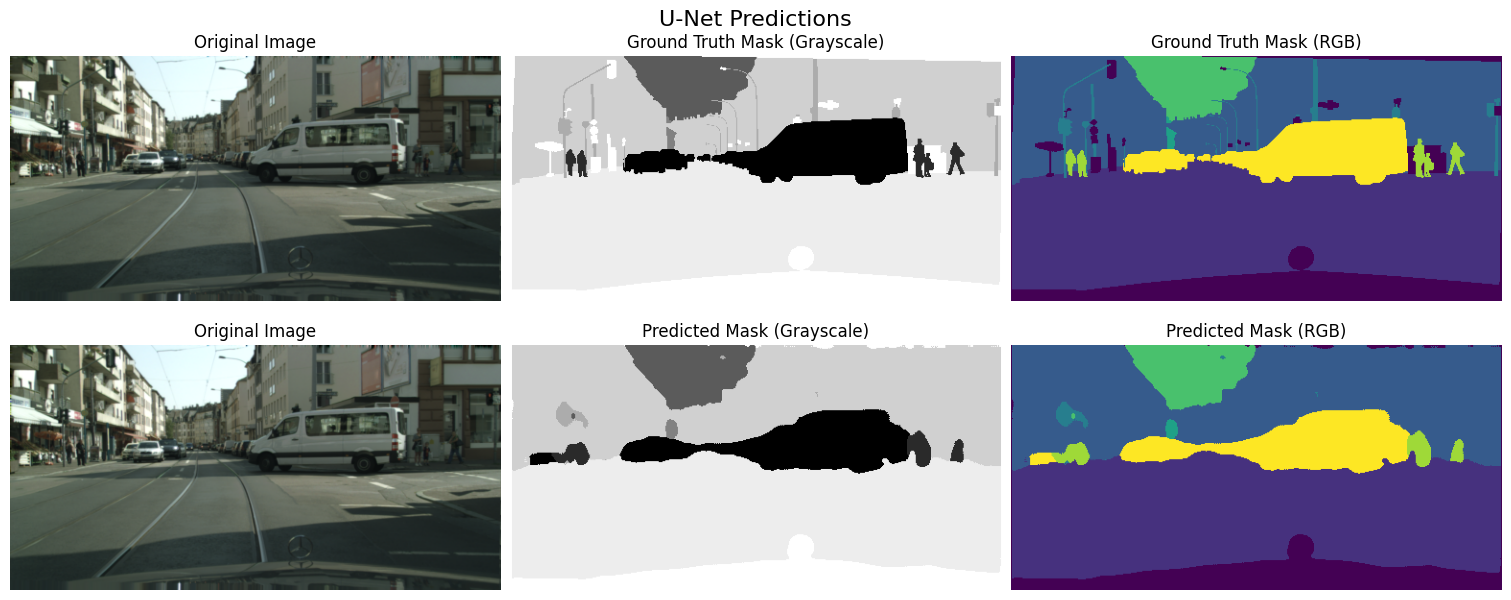

In [143]:
test_datagen.show_prediction(model=model, index=5)

## 5.3. FocalLoss & DICE

In [ ]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
# Create the model
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

# Folder to create to store artifacts
new_folder = 53

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=5,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Define the loss function
loss_fn = DiceFocalLoss(
    num_classes=train_datagen.num_classes,
    from_logits=False,
    smooth=1e-6,
    alpha=0.7,
    gamma=2.0,
    name="dice_focal_loss",
)


# Define the optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

# Train the model
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping],
)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 3754s 25s/step - Dice: 0.3283 - IoU_class_0: 0.2668 - IoU_class_1: 0.5315 - IoU_class_2: 0.3346 - IoU_class_3: 0.0651 - IoU_class_4: 0.3414 - IoU_class_5: 0.2193 - IoU_class_6: 0.1766 - IoU_class_7: 0.2732 - MeanIoU: 0.2761 - Pixel_Accuracy: 0.5833 - loss: 1.1358 - val_Dice: 0.4189 - val_IoU_class_0: 0.2979 - val_IoU_class_1: 0.8037 - val_IoU_class_2: 0.3634 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.4170 - val_IoU_class_5: 0.5451 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.1958 - val_MeanIoU: 0.3279 - val_Pixel_Accuracy: 0.6670 - val_loss: 0.7614
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 3705s 25s/step - Dice: 0.4521 - IoU_class_0: 0.4139 - IoU_class_1: 0.8073 - IoU_class_2: 0.4324 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.4364 - IoU_class_5: 0.6254 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.2364 - MeanIoU: 0.3690 - Pixel_Accuracy: 0.6978 - loss: 0.7118 - val_Dice: 0.4923 - val_IoU_class_0: 0.4127 - val_IoU_class_1: 0.8248 - val_Io

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/53/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Inference time on a unique prediction: 0.48 seconds


In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/53/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

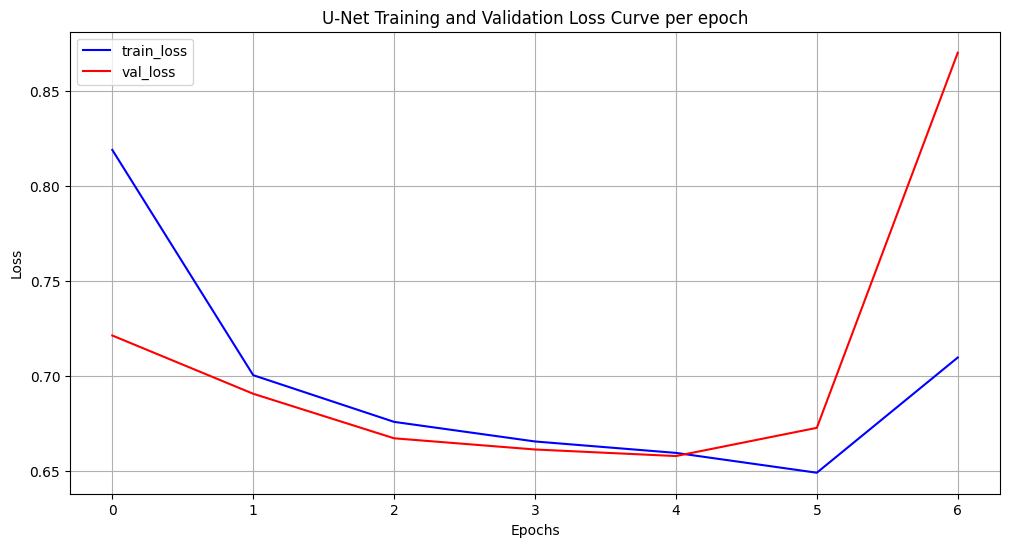

In [ ]:
model_metric.plot_loss()

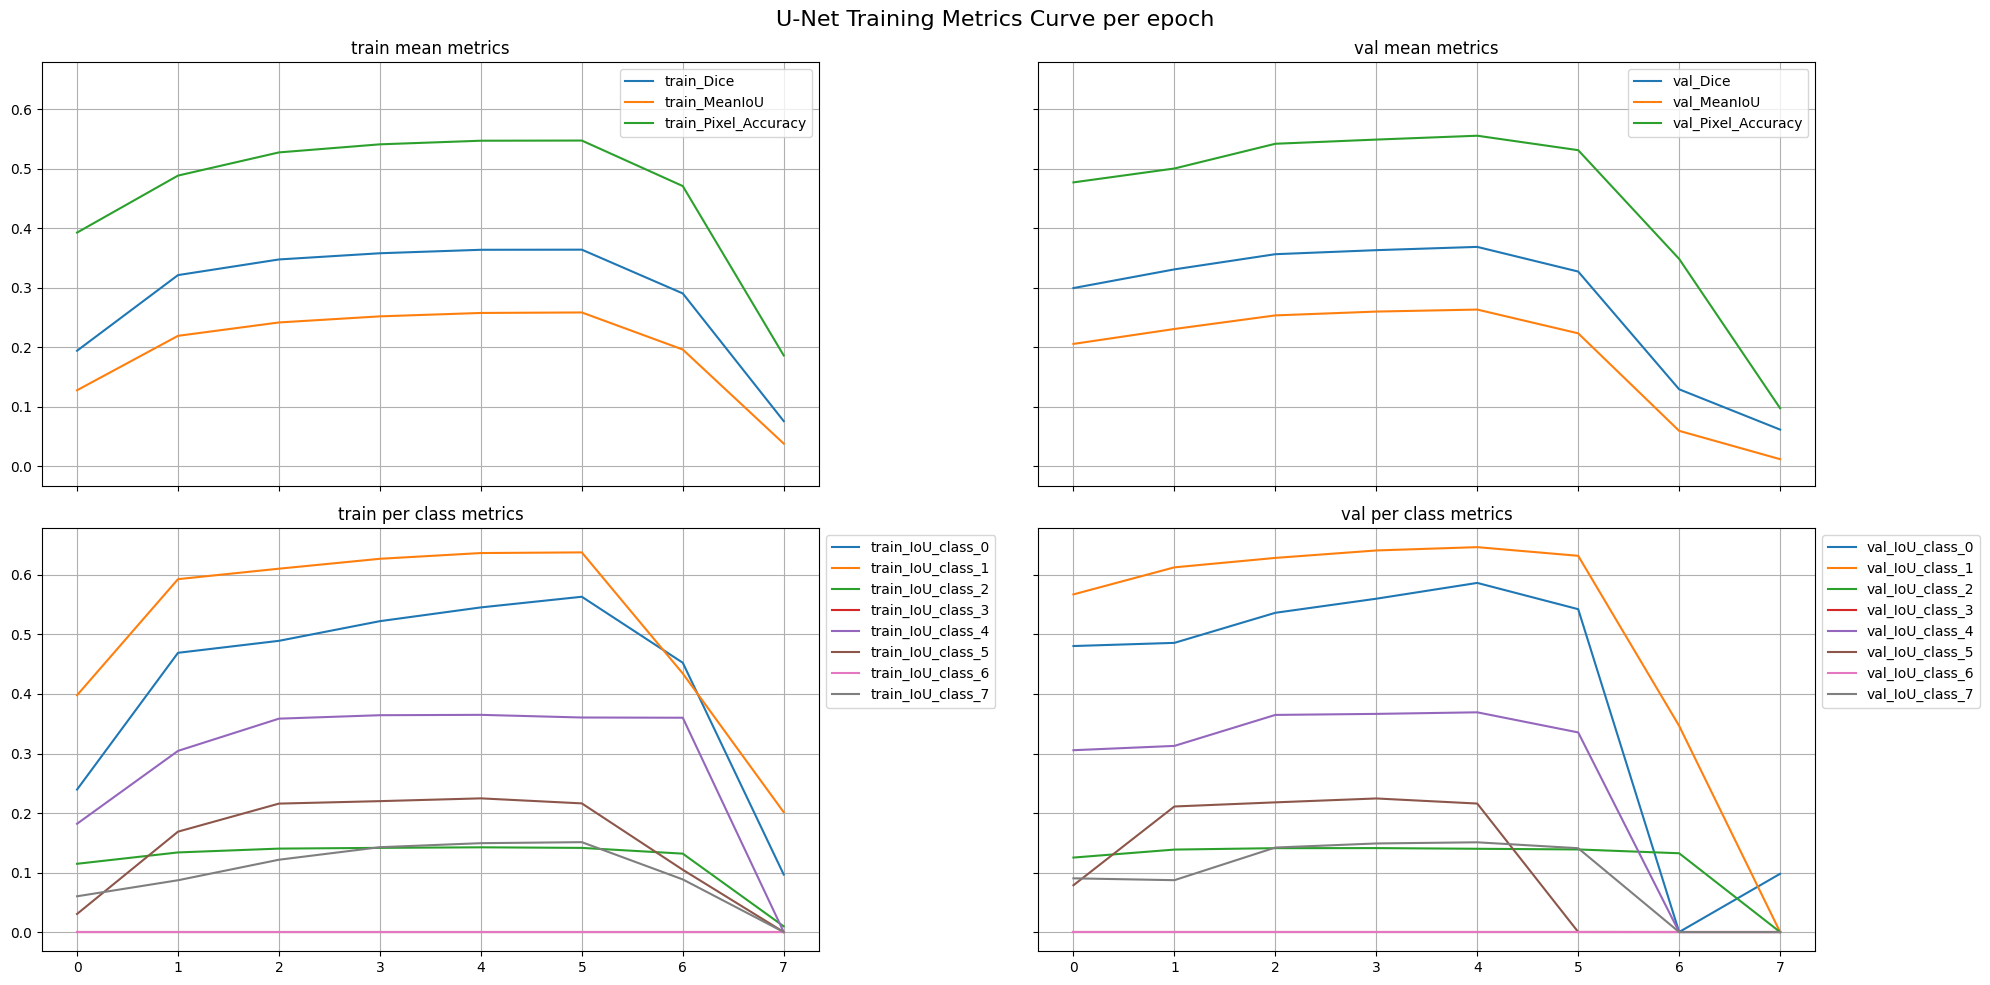

In [ ]:
model_metric.plot_train_metrics()

<Axes: >

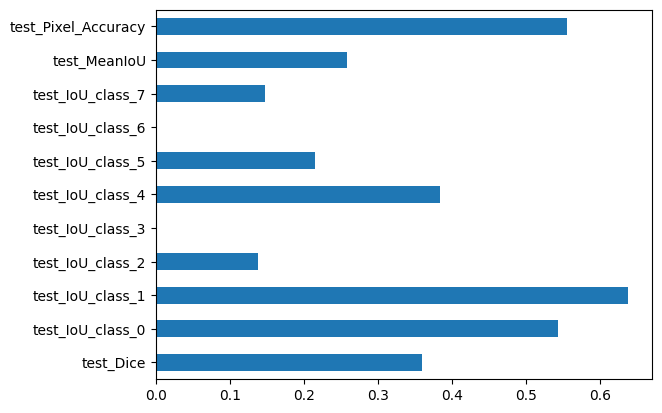

In [ ]:
model_metric.metrics_df.filter(like="test", axis=1).T[:-2].plot(
    kind="barh", legend=False
)

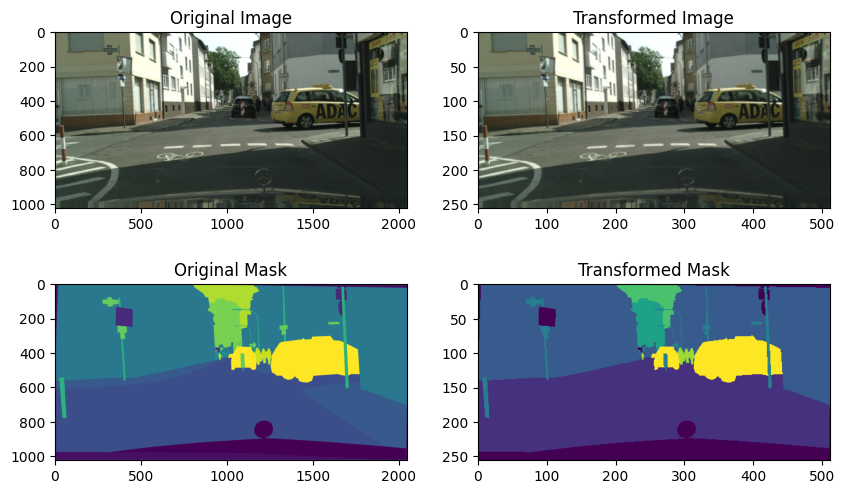

In [ ]:
test_datagen.show_transformation(index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


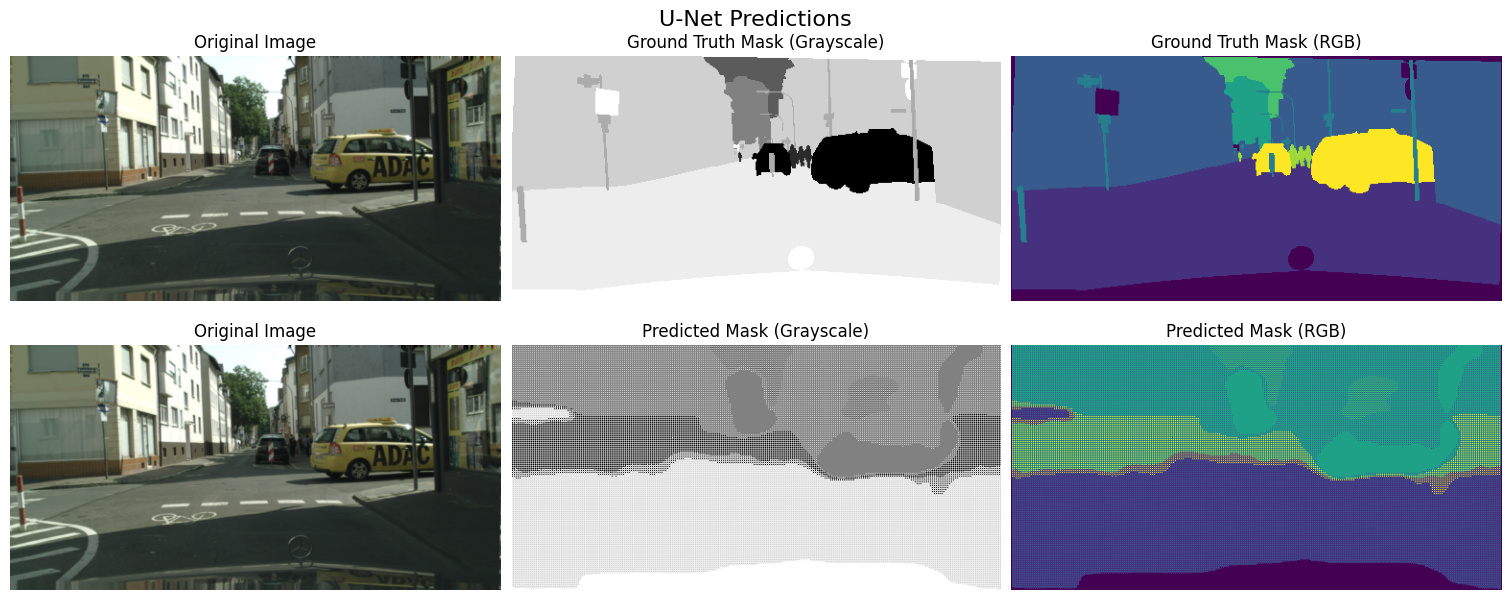

In [ ]:
test_datagen.show_prediction(model=model, index=0)

## 5.4. SCCE + DataAugmentation

In [ ]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=True,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
# Create the model
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

# Folder to create to store artifacts
new_folder = 54

# Create a model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/best_model.keras",  # Save under keras format to avoid WARNING
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to save the best model
    mode="max",
    save_best_only=True,
    verbose=0,
)

# Create an early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_MeanIoU",  # Set Mean IoU as the metric to monitor to stop the training
    patience=5,  # Epochs to wait before stopping
    mode="max",
    verbose=1,
)

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,  # Set to False if y_pred is a probability distribution
    name="sparse_categorical_crossentropy",
)

# Define the optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

# Train the model
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping],
)

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 3705s 25s/step - Dice: 0.3162 - IoU_class_0: 0.2714 - IoU_class_1: 0.5237 - IoU_class_2: 0.3232 - IoU_class_3: 0.0114 - IoU_class_4: 0.3288 - IoU_class_5: 0.2912 - IoU_class_6: 0.1367 - IoU_class_7: 0.2724 - MeanIoU: 0.2698 - Pixel_Accuracy: 0.5794 - loss: 1.7744 - val_Dice: 0.3678 - val_IoU_class_0: 0.3353 - val_IoU_class_1: 0.7835 - val_IoU_class_2: 0.3275 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.4002 - val_IoU_class_5: 0.4307 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 3.4977e-06 - val_MeanIoU: 0.2847 - val_Pixel_Accuracy: 0.6444 - val_loss: 0.9552
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 3657s 25s/step - Dice: 0.4040 - IoU_class_0: 0.4254 - IoU_class_1: 0.7549 - IoU_class_2: 0.3872 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.3621 - IoU_class_5: 0.6056 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0424 - MeanIoU: 0.3222 - Pixel_Accuracy: 0.6632 - loss: 0.9061 - val_Dice: 0.4944 - val_IoU_class_0: 0.4979 - val_IoU_class_1: 0.8261 - va

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/54/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/54/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

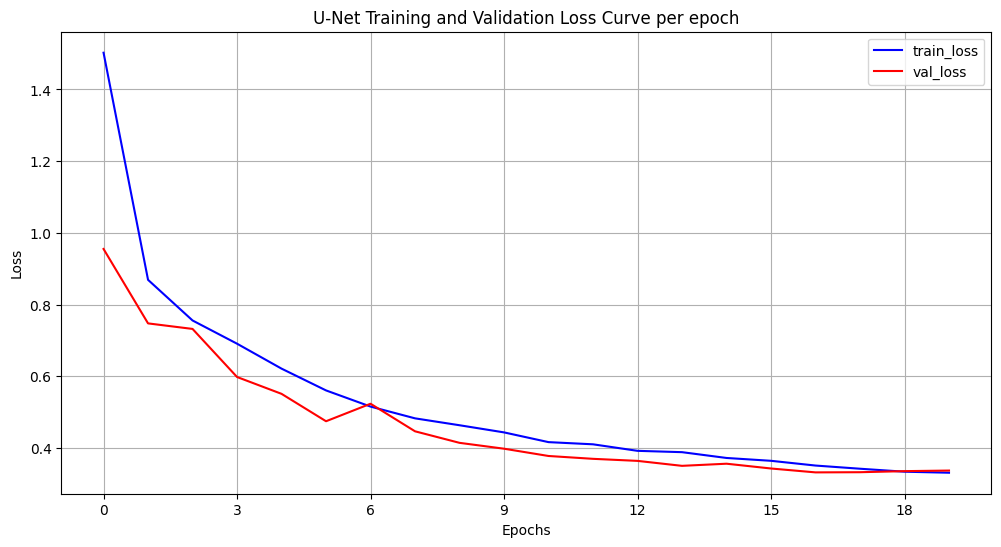

In [49]:
model_metric.plot_loss()

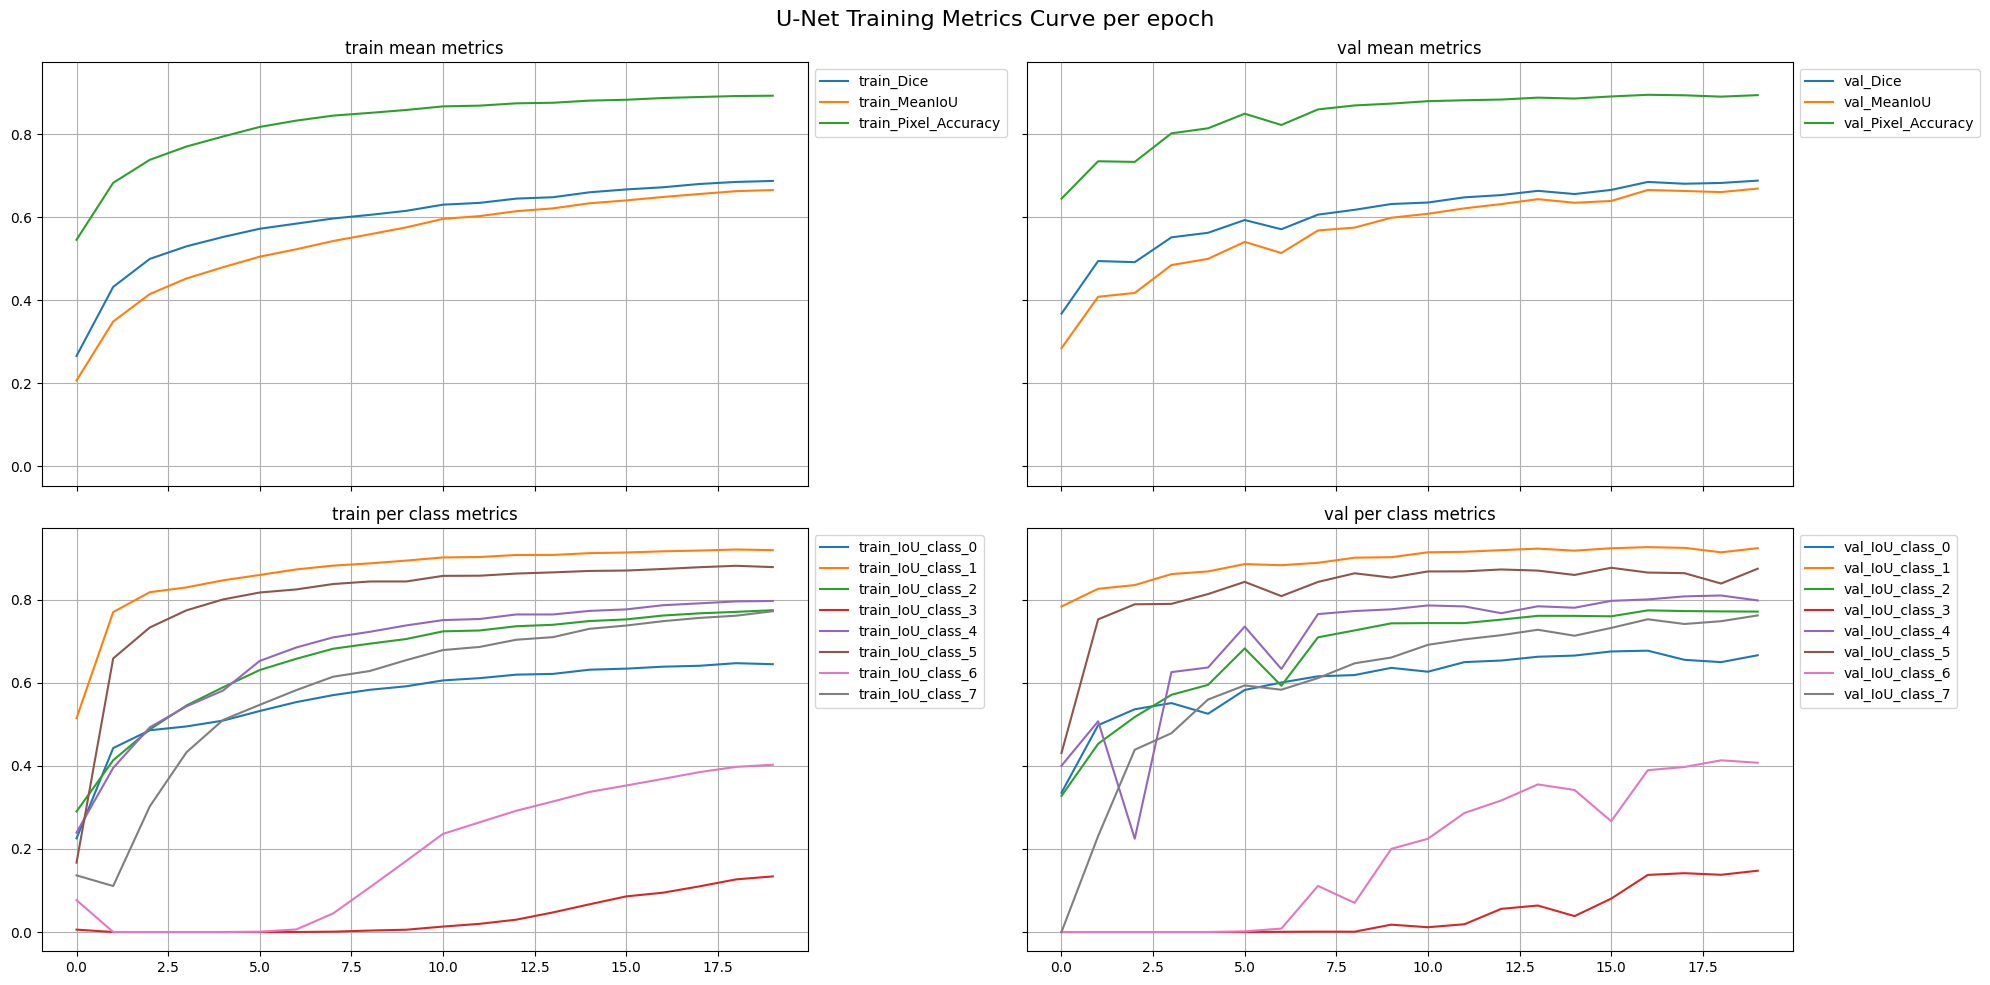

In [50]:
model_metric.plot_train_metrics()

In [51]:
model_metric.save_metrics()

Metrics file updated at ../metrics.csv
History file created at ../artifacts
Test results created at ../artifacts


<Axes: >

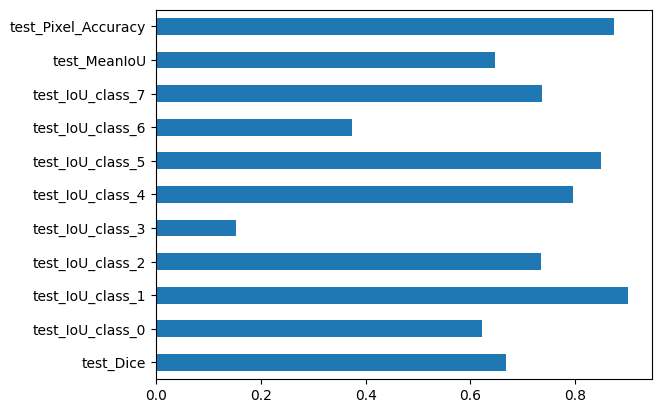

In [52]:
model_metric.metrics_df.filter(like="test", axis=1).T[:-2].plot(
    kind="barh", legend=False
)

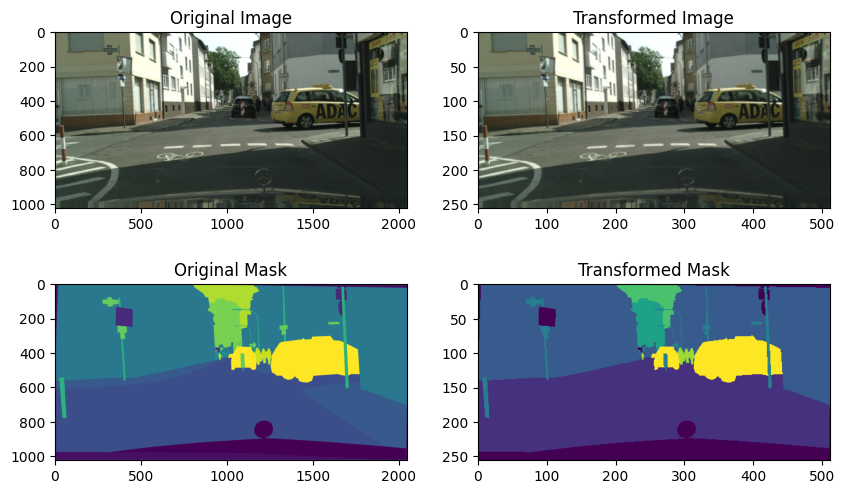

In [53]:
test_datagen.show_transformation(index=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


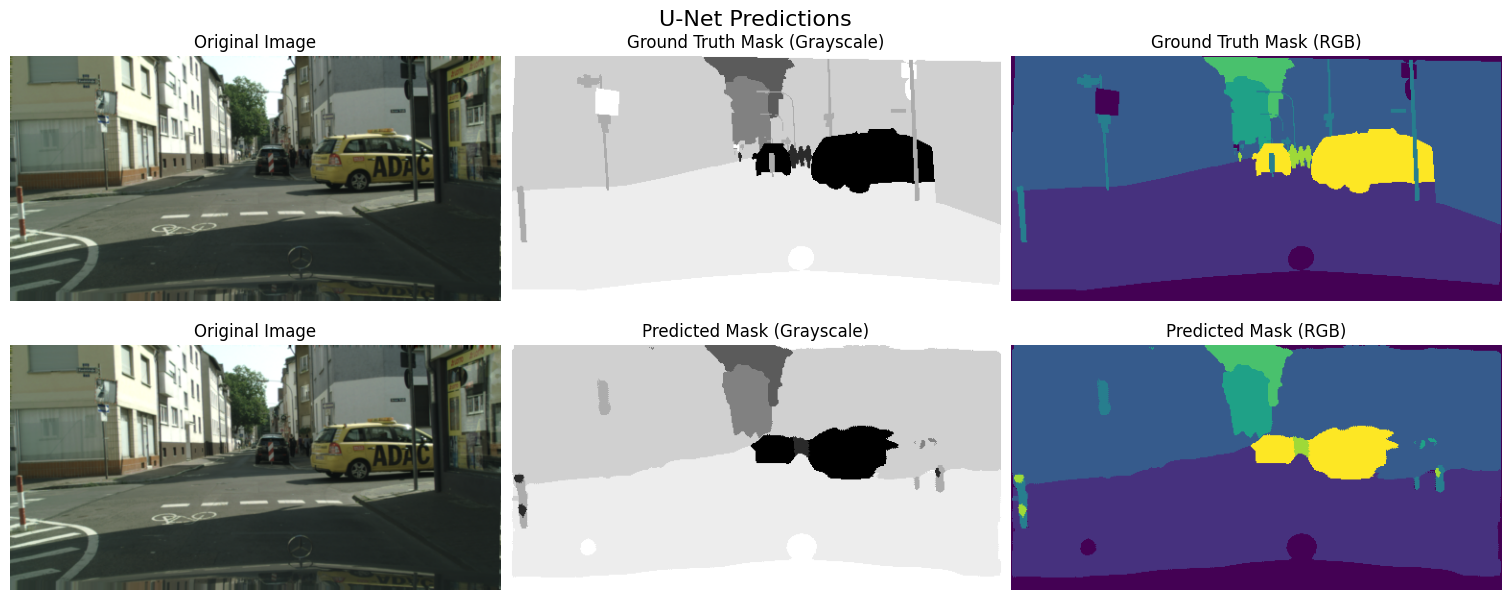

In [54]:
test_datagen.show_prediction(model=model, index=0)

## 5.5. BestLoss + DataAugmentation

In [ ]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=True,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
# Create the model
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)

# Folder to create to store artifacts
new_folder = 55

# TO DEFINE

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/55/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/55/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

In [ ]:
# metrics to plot

## Résultats

# 6. Advanced Architectures

## 6.1. UNET DECODER + ENCODER RESNET (+imagepreprocessing)

In [ ]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=True,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [ ]:
import segmentation_models as sm
# Segmentation Models: using `keras` framework.

In [ ]:
# Create the model
BACKBONE = "resnet34"
model = sm.Unet(
    BACKBONE,
    classes=train_datagen.num_classes,
    activation="softmax",
    encoder_weights="imagenet",
    input_shape=(256, 512, 3),
)

# Folder to create to store artifacts
new_folder = 61

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/61/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/61/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

https://github.com/qubvel/segmentation_models

In [ ]:
model = sm.Unet()

In [ ]:
# multiclass segmentation with non overlapping class masks (your classes + background)
BACKBONE = "resnet34"
model = sm.Unet(
    BACKBONE,
    classes=3,
    activation="softmax",
    encoder_weights="imagenet",
    input_shape=(256, 512, 3),
)

In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)

## 6.2. FPN DECODER + EFFICIENT NET ENCODER

In [ ]:
train_datagen = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=True,
    shuffle=True,
)

val_datagen = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

test_datagen = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=16,  # We won't use batches here
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    augmentations=False,
    shuffle=False,
)

In [145]:
# Create the model
BACKBONE = "efficientnetb0"
model = sm.FPN(
    BACKBONE,
    classes=train_datagen.num_classes,
    activation="softmax",
    encoder_weights="imagenet",
    input_shape=(256, 512, 3),
)

# Folder to create to store artifacts
new_folder = 62

NameError: name 'sm' is not defined

In [ ]:
# Recharge les meilleurs poids enregistrés lors de l'entraînement
model.load_weights("../artifacts/62/best_model.keras")

# Evaluation on the test set
results = model.evaluate(test_datagen, return_dict=True)

# Get a fixed test img for computing inference time and for further visualization
start_time = time.time()
img_preds = test_datagen.get_prediction(model, 11)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time on a unique prediction: {end_time - start_time:.2f} seconds")

In [ ]:
try:
    model_metric = ModelMetric.from_pickle(
        pickle_path="../artifacts/62/model_metric.pkl"
    )
except FileNotFoundError:
    # Set the extra_metrics to save in the ModelMetric object
    extra_metrics = {
        "experiment_folder": new_folder,  # experiment_folder is mandatory to save the metrics
        "inference_time": inference_time,
        "classes": train_datagen.num_classes,
        "train_samples": train_datagen.num_samples,
        "val_samples": val_datagen.num_samples,
        "test_samples": test_datagen.num_samples,
        "train_batches": len(train_datagen),
        "augmentations": str(train_datagen.augmentations),
        "normalize": str(train_datagen.normalize),
        "loss_fn": loss_fn.name,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": float(optimizer.learning_rate.value.numpy()),
        # "weight_decay": float(optimizer.weight_decay.value.numpy()),
    }

    # Create the ModelMetric object
    model_metric = ModelMetric(
        history=history,
        results=results,
        extra_metrics=extra_metrics,
        monitor="val_MeanIoU",
        best_monitor="max",
    )

    # Save the metrics
    model_metric.save_metrics()

## 6.3. SOTA ?

# 7. Conclusion